## 1.ËØªÂèñpackage

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.base import BaseEstimator, ClusterMixin, clone
import pickle
import warnings
from sklearn.utils import check_random_state
from fcmeans import FCM
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import cdist
from sklearn.metrics import normalized_mutual_info_score
from tqdm import tqdm  # Import tqdm for progress bars
from scipy.stats import sem
from scipy.stats import t
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
np.random.seed(2024)
random_state = check_random_state(2024)

class FCMWrapper(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=2, fuzziness=2.0, max_iter=1000, error=1e-5, random_state=2024, init='k-means++'):
        self.n_clusters = n_clusters
        self.fuzziness = fuzziness
        self.max_iter = max_iter
        self.error = error
        self.random_state = random_state
        self.init = init
        
    def fit(self, X, y=None):
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        kmeans = KMeans(n_clusters=self.n_clusters, init=self.init, random_state=self.random_state)
        kmeans.fit(X)
        initial_centers = kmeans.cluster_centers_
        
        self.fcm = FCM(n_clusters=self.n_clusters, m=self.fuzziness, max_iter=self.max_iter, error=self.error, 
                       random_state=self.random_state, initial_centers=initial_centers)
        self.fcm.fit(X)
        return self
    
    def predict(self, X):
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        return self.fcm.predict(X)
    
    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.predict(X)
    
    @property
    def u_(self):
        return self.fcm.u
    
    @property
    def centers(self):
        return self.fcm.centers
    
    def fuzzy_partition_coefficient(self):
        u = self.u_
        return np.sum(u ** 2) / u.shape[0]  # ËÆ°ÁÆó Fuzzy Partition Coefficient (FPC)


def kwons_v_k_score_func(estimator, X):
    u = estimator.u_
    centers = estimator.centers
    distances = cdist(X, centers, metric='sqeuclidean')
    score = np.sum(u * distances)
    return (1.0 / score * 100) if score != 0 else np.inf  # Èò≤Ê≠¢Èô§‰ª•Èõ∂ÔºåÂπ∂ÊîæÂ§ß 100 ÂÄç

# Custom scoring function for Fuzzy Silhouette Index
def fuzzy_silhouette_score_func(estimator, X):
    labels = estimator.predict(X)
    return silhouette_score(X, labels)

def xie_beni_score_func(estimator, X):
    estimator.fit(X)
    u = estimator.u_
    centroids = estimator.centers
    n_samples = X.shape[0]
    m = estimator.fuzziness
    distances_squared = cdist(X, centroids, metric='sqeuclidean')
    compactness = np.sum((u ** m) * distances_squared)
    centroids_dist_squared = cdist(centroids, centroids, metric='sqeuclidean')
    np.fill_diagonal(centroids_dist_squared, np.inf)
    separation = np.min(centroids_dist_squared)
    
    if separation == 0:
        return np.inf
    
    xie_beni_index = compactness / (n_samples * separation)
    
    return xie_beni_index

def objective_function(estimator, X):
    u = estimator.u_
    centers = estimator.centers
    m = estimator.fuzziness
    distances = cdist(X, centers, metric='sqeuclidean')
    return np.sum((u ** m) * distances)


## 2.FCMËÅöÁ±ª

In [3]:
data = pd.read_excel('/Users/zhangtongyi/Desktop/P0022024-ËÆ§Áü•ËÅöÁ±ª-project(ÊúÄÊñ∞ÁâàÔºâ/A.ÊúÄÊñ∞ÁâàÊú¨/3.ÊéßÂà∂total PANSS Scores/2.ËÅöÁ±ªÂàÜÊûê-ÊéßÂà∂PANSS total/0.Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜ/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /ÁªìÊûúEFÂ¢ûÂä†ÂõûÂΩíÊéâPANSStotal.xlsx')
EFs_data = data[['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc', 'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']]

fcm_param_grid = {
    'n_clusters': list(range(2, 8)),
    'fuzziness': np.arange(1.5, 2.55, 0.25).tolist(),
    'random_state': [2024],
    'max_iter': [1000],
    'error': [1e-5],
    'init': ['k-means++']
}

best_params_scores = {}
membership_matrices = {}
all_results = {}
best_results = {}

for n_clusters in tqdm(range(2, 8), desc="Clustering Progress"):
    print(f"ÁõÆÂâçÊ≠£Âú®ËøêË°åÁöÑËÅöÁ±ªÊï∞ÁõÆÔºö{n_clusters}")
    
    best_fuzzy_silhouette_score = -np.inf
    best_model = None
    best_fuzziness = None
    
    for fuzziness in np.arange(1.5, 2.55, 0.25):
        fcm_grid_search = GridSearchCV(FCMWrapper(n_clusters=n_clusters, fuzziness=fuzziness), 
                                       {k: v for k, v in fcm_param_grid.items() if k not in ['n_clusters', 'fuzziness']}, 
                                       cv=RepeatedKFold(n_splits=10, n_repeats=100, random_state=2024),
                                       scoring={
                                           'fuzzy_silhouette': fuzzy_silhouette_score_func,
                                           'xie_beni': xie_beni_score_func,
                                           'kwons_v_k': kwons_v_k_score_func
                                       },
                                       refit='fuzzy_silhouette', n_jobs=-1, verbose=0)

        fcm_grid_search.fit(EFs_data)
        best_model_current = fcm_grid_search.best_estimator_
        
        obj_func_values = []
        center_changes = []
        prev_centers = None
        num_iterations_to_check = 1
        count_converged = 0
        converged = False

        for iteration in range(best_model_current.max_iter):
            best_model_current.fit(EFs_data)
            obj_func_value = objective_function(best_model_current, EFs_data)
            obj_func_values.append(obj_func_value)
            
            if prev_centers is not None:
                center_change = np.sum(np.abs(best_model_current.centers - prev_centers))
                center_changes.append(center_change)
                
                if center_change < best_model_current.error:
                    count_converged += 1
                    if count_converged >= num_iterations_to_check:
                        converged = True
                else:
                    count_converged = 0
            
            prev_centers = best_model_current.centers.copy()

        if converged:
            print(f"FCM converged after {len(center_changes)} iterations for n_clusters = {n_clusters}, fuzziness = {fuzziness}")
        else:
            print(f"FCM did not converge after {best_model_current.max_iter} iterations for n_clusters = {n_clusters}, fuzziness = {fuzziness}")

        fcm_best_params = fcm_grid_search.best_params_
        fcm_best_score = fcm_grid_search.best_score_

        mean_fuzzy_silhouette_score = fcm_grid_search.cv_results_['mean_test_fuzzy_silhouette'][fcm_grid_search.best_index_]
        std_fuzzy_silhouette_score = fcm_grid_search.cv_results_['std_test_fuzzy_silhouette'][fcm_grid_search.best_index_]

        mean_xie_beni_score = fcm_grid_search.cv_results_['mean_test_xie_beni'][fcm_grid_search.best_index_]
        std_xie_beni_score = fcm_grid_search.cv_results_['std_test_xie_beni'][fcm_grid_search.best_index_]

        mean_kwons_v_k_score = fcm_grid_search.cv_results_['mean_test_kwons_v_k'][fcm_grid_search.best_index_]
        std_kwons_v_k_score = fcm_grid_search.cv_results_['std_test_kwons_v_k'][fcm_grid_search.best_index_]

        membership_matrix = fcm_grid_search.best_estimator_.u_

        membership_matrices[(n_clusters, fuzziness)] = membership_matrix

        all_results[(n_clusters, fuzziness)] = {
            'best_model': fcm_grid_search.best_estimator_,
            'best_params': fcm_best_params,
            'best_score': fcm_best_score,
            'mean_fuzzy_silhouette_score': mean_fuzzy_silhouette_score,
            'std_fuzzy_silhouette_score': std_fuzzy_silhouette_score,
            'mean_xie_beni_score': mean_xie_beni_score,
            'std_xie_beni_score': std_xie_beni_score,
            'mean_kwons_v_k_score': mean_kwons_v_k_score,
            'std_kwons_v_k_score': std_kwons_v_k_score,
            'membership_matrix': membership_matrix
        }

        if mean_fuzzy_silhouette_score > best_fuzzy_silhouette_score:
            best_fuzzy_silhouette_score = mean_fuzzy_silhouette_score
            best_model = fcm_grid_search.best_estimator_
            best_fuzziness = fuzziness

    best_results[n_clusters] = {
        'best_model': best_model,
        'best_fuzziness': best_fuzziness,
        'best_fuzzy_silhouette_score': best_fuzzy_silhouette_score,
        'best_xie_beni_score': mean_xie_beni_score,
        'best_kwons_v_k_score': mean_kwons_v_k_score
    }

    with open(f'./pkl/fcm_best_model_n_clusters_{n_clusters}.pkl', 'wb') as f:
        pickle.dump(best_model, f)


Clustering Progress:   0%|          | 0/6 [00:00<?, ?it/s]

ÁõÆÂâçÊ≠£Âú®ËøêË°åÁöÑËÅöÁ±ªÊï∞ÁõÆÔºö2
FCM converged after 999 iterations for n_clusters = 2, fuzziness = 1.5
FCM converged after 999 iterations for n_clusters = 2, fuzziness = 1.75
FCM converged after 999 iterations for n_clusters = 2, fuzziness = 2.0
FCM converged after 999 iterations for n_clusters = 2, fuzziness = 2.25


Clustering Progress:  17%|‚ñà‚ñã        | 1/6 [00:19<01:37, 19.42s/it]

FCM converged after 999 iterations for n_clusters = 2, fuzziness = 2.5
ÁõÆÂâçÊ≠£Âú®ËøêË°åÁöÑËÅöÁ±ªÊï∞ÁõÆÔºö3
FCM converged after 999 iterations for n_clusters = 3, fuzziness = 1.5
FCM converged after 999 iterations for n_clusters = 3, fuzziness = 1.75
FCM converged after 999 iterations for n_clusters = 3, fuzziness = 2.0
FCM converged after 999 iterations for n_clusters = 3, fuzziness = 2.25


Clustering Progress:  33%|‚ñà‚ñà‚ñà‚ñé      | 2/6 [00:59<02:05, 31.49s/it]

FCM converged after 999 iterations for n_clusters = 3, fuzziness = 2.5
ÁõÆÂâçÊ≠£Âú®ËøêË°åÁöÑËÅöÁ±ªÊï∞ÁõÆÔºö4
FCM converged after 999 iterations for n_clusters = 4, fuzziness = 1.5
FCM converged after 999 iterations for n_clusters = 4, fuzziness = 1.75
FCM converged after 999 iterations for n_clusters = 4, fuzziness = 2.0
FCM converged after 999 iterations for n_clusters = 4, fuzziness = 2.25


Clustering Progress:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 3/6 [01:44<01:53, 37.77s/it]

FCM converged after 999 iterations for n_clusters = 4, fuzziness = 2.5
ÁõÆÂâçÊ≠£Âú®ËøêË°åÁöÑËÅöÁ±ªÊï∞ÁõÆÔºö5
FCM converged after 999 iterations for n_clusters = 5, fuzziness = 1.5
FCM converged after 999 iterations for n_clusters = 5, fuzziness = 1.75
FCM converged after 999 iterations for n_clusters = 5, fuzziness = 2.0
FCM converged after 999 iterations for n_clusters = 5, fuzziness = 2.25


Clustering Progress:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 4/6 [02:45<01:34, 47.00s/it]

FCM converged after 999 iterations for n_clusters = 5, fuzziness = 2.5
ÁõÆÂâçÊ≠£Âú®ËøêË°åÁöÑËÅöÁ±ªÊï∞ÁõÆÔºö6
FCM converged after 999 iterations for n_clusters = 6, fuzziness = 1.5
FCM converged after 999 iterations for n_clusters = 6, fuzziness = 1.75
FCM converged after 999 iterations for n_clusters = 6, fuzziness = 2.0
FCM converged after 999 iterations for n_clusters = 6, fuzziness = 2.25


Clustering Progress:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 5/6 [04:01<00:57, 57.53s/it]

FCM converged after 999 iterations for n_clusters = 6, fuzziness = 2.5
ÁõÆÂâçÊ≠£Âú®ËøêË°åÁöÑËÅöÁ±ªÊï∞ÁõÆÔºö7
FCM converged after 999 iterations for n_clusters = 7, fuzziness = 1.5
FCM converged after 999 iterations for n_clusters = 7, fuzziness = 1.75
FCM converged after 999 iterations for n_clusters = 7, fuzziness = 2.0
FCM converged after 999 iterations for n_clusters = 7, fuzziness = 2.25


Clustering Progress: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [05:11<00:00, 51.91s/it]

FCM converged after 999 iterations for n_clusters = 7, fuzziness = 2.5


## 3.Á®≥ÂÆöÊÄßÂàÜÊûê

In [4]:
# Clustering metrics for K = 2 cluster solutions
# Á®≥ÂÆöÊÄßÂàÜÊûê - ‰ΩøÁî® subsamplingÔºàÊó†ÊîæÂõûÊäΩÊ†∑Ôºâ
import numpy as np
import pickle
from sklearn.base import clone
from sklearn.metrics import adjusted_rand_score
from scipy.stats import sem, t

# ÂÅáËÆæ best_results, all_results, membership_matrices, fcm_param_grid, EFs_data ÈÉΩÂ∑≤ÂÆö‰πâÂπ∂ËΩΩÂÖ•

num_subsamples = 1000
subsample_size = int(0.85 * len(EFs_data))

for n_clusters, result in best_results.items():
    print(f"Performing stability analysis for n_clusters = {n_clusters}")
    best_model = result['best_model']

    stabilities = []
    fuzzy_silhouette_scores = []
    xie_beni_scores = []
    kwons_v_k_scores = []

    for i in range(num_subsamples):
        np.random.seed(42 + i)

        # Êó†ÊîæÂõûÊäΩÊ†∑ÔºàsubsamplingÔºâ
        subsample_indices = np.random.choice(len(EFs_data), subsample_size, replace=False)
        subsample_data = EFs_data.iloc[subsample_indices]

        # ÈáçÊñ∞ÊãüÂêàÊ®°ÂûãÂπ∂ËÆ°ÁÆóÊ†áÁ≠æ
        subsample_fcm = clone(best_model)
        subsample_fcm.fit(subsample_data)
        subsample_labels = np.argmax(subsample_fcm.u_, axis=1)

        # ÂéüÂßãÂÖ®Êï∞ÊçÆÊ†áÁ≠æ
        full_data_labels = np.argmax(best_model.u_, axis=1)
        subsample_full_labels = full_data_labels[subsample_indices]

        # ARI stability
        stability = adjusted_rand_score(subsample_labels, subsample_full_labels)
        stabilities.append(stability)

        # Ê®°Á≥äËΩÆÂªìÂæóÂàÜ
        fss = fuzzy_silhouette_score_func(subsample_fcm, subsample_data)
        fuzzy_silhouette_scores.append(fss)

        # Xie‚ÄìBeni ÊåáÊ†á
        xb = xie_beni_score_func(subsample_fcm, subsample_data)
        xie_beni_scores.append(xb)

        # Kwon‚Äôs V-K ÊåáÊ†á
        kvk = kwons_v_k_score_func(subsample_fcm, subsample_data)
        kwons_v_k_scores.append(kvk)

    # ËÆ°ÁÆó 95% ÁΩÆ‰ø°Âå∫Èó¥
    confidence_level = 0.95
    df = len(stabilities) - 1

    stability_mean = np.mean(stabilities)
    stability_se = sem(stabilities)
    stability_ci = t.interval(confidence_level, df, loc=stability_mean, scale=stability_se)

    fss_mean = np.mean(fuzzy_silhouette_scores)
    fss_se = sem(fuzzy_silhouette_scores)
    fss_ci = t.interval(confidence_level, df, loc=fss_mean, scale=fss_se)

    xb_mean = np.mean(xie_beni_scores)
    xb_se = sem(xie_beni_scores)
    xb_ci = t.interval(confidence_level, df, loc=xb_mean, scale=xb_se)

    kvk_mean = np.mean(kwons_v_k_scores)
    kvk_se = sem(kwons_v_k_scores)
    kvk_ci = t.interval(confidence_level, df, loc=kvk_mean, scale=kvk_se)

    # Â≠òÂÇ®ÁªìÊûúÂà∞ result
    result.update({
        'stability_sample_mean': stability_mean,
        'stability_ci_lower': stability_ci[0],
        'stability_ci_upper': stability_ci[1],
        'fss_sample_mean': fss_mean,
        'fss_ci_lower': fss_ci[0],
        'fss_ci_upper': fss_ci[1],
        'xb_sample_mean': xb_mean,
        'xb_ci_lower': xb_ci[0],
        'xb_ci_upper': xb_ci[1],
        'kvk_sample_mean': kvk_mean,
        'kvk_ci_lower': kvk_ci[0],
        'kvk_ci_upper': kvk_ci[1]
    })

    print(f"n_clusters = {n_clusters}: ARI stability mean = {stability_mean:.4f}, "
          f"CI: ({stability_ci[0]:.4f}, {stability_ci[1]:.4f})")

# ‰øùÂ≠òÊâÄÊúâÁªìÊûúÂíåÊ®°Âûã
all_results_df = pd.DataFrame.from_dict(all_results, orient='index')
all_results_df.to_excel('./table/fcm_all_results.xlsx', index_label=['n_clusters', 'fuzziness'])

best_results_df = pd.DataFrame.from_dict(best_results, orient='index')
best_results_df.to_excel('./table/fcm_best_results.xlsx', index_label='n_clusters')
best_results_df.to_pickle('./pkl/fcm_best_results_df.pkl')

with open('./pkl/fcm_best_results.pkl', 'wb') as f:
    pickle.dump(best_results, f)

with open('./pkl/fcm_membership_matrices.pkl', 'wb') as f:
    pickle.dump(membership_matrices, f)

with open('./pkl/fcm_param_grid.pkl', 'wb') as f:
    pickle.dump(fcm_param_grid, f)

EFs_data.to_pickle('./pkl/EFs_data.pkl')

print("ÊâÄÊúâÁªìÊûúÂíåÊ®°ÂûãÂùáÂ∑≤‰øùÂ≠òÂÆåÊàê„ÄÇ")


Performing stability analysis for n_clusters = 2
n_clusters = 2: ARI stability mean = 0.9597, CI: (0.9561, 0.9632)
Performing stability analysis for n_clusters = 3
n_clusters = 3: ARI stability mean = 0.9136, CI: (0.9102, 0.9170)
Performing stability analysis for n_clusters = 4
n_clusters = 4: ARI stability mean = 0.9564, CI: (0.9544, 0.9584)
Performing stability analysis for n_clusters = 5
n_clusters = 5: ARI stability mean = 0.9263, CI: (0.9232, 0.9294)
Performing stability analysis for n_clusters = 6
n_clusters = 6: ARI stability mean = 0.8667, CI: (0.8583, 0.8750)
Performing stability analysis for n_clusters = 7
n_clusters = 7: ARI stability mean = 0.9099, CI: (0.9049, 0.9148)
ÊâÄÊúâÁªìÊûúÂíåÊ®°ÂûãÂùáÂ∑≤‰øùÂ≠òÂÆåÊàê„ÄÇ


## 4.‰∏çÂêåk‰∏é‰∏çÂêåm‰∏ãÁöÑÁ®≥ÂÆöÊÄßÂàÜÊûê

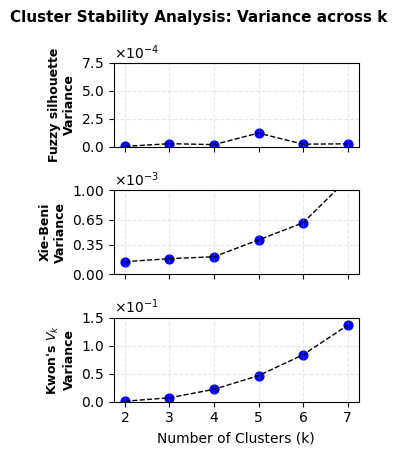

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

# ËØªÂèñExcelÊñá‰ª∂
history = pd.read_excel('table/fcm_all_resultsÁöÑÂâØÊú¨.xlsx')

# ÂÆö‰πâËØÑ‰º∞ÊåáÊ†á
metrics = ['mean_fuzzy_silhouette_score', 'mean_xie_beni_score', 'mean_kwons_v_k_score'] 
metric_labels = ['Fuzzy silhouette', 'Xie-Beni', r"Kwon's $V_k$"]

# ËÆ°ÁÆóÊØè‰∏™ k ‰∏ã‰∏çÂêåËØÑ‰º∞ÊåáÊ†áÁöÑÊñπÂ∑Æ
var_results = history.groupby('n_clusters')[metrics].var().reset_index()

# ÂàõÂª∫ÂõæË°®
fig, axs = plt.subplots(3, 1, figsize=(3.5, 4.5), sharex=True)

# ÂÆö‰πâÊØè‰∏™ËØÑ‰º∞ÊåáÊ†áÁöÑÂÖ∑‰ΩìYËΩ¥ËåÉÂõ¥
y_limits = [(0, 0.00075),   # Fuzzy silhouette
            (0, 0.0010),    # Xie-Beni 
            (0, 0.15)]      # Kwon's Vk

# ÂÆö‰πâÊØè‰∏™ËØÑ‰º∞ÊåáÊ†áÁöÑÂàªÂ∫¶Êï∞Èáè
y_ticks = [
    [0, 0.00025, 0.0005, 0.00075],
    [0, 0.00035, 0.00065, 0.0010],
    [0, 0.05, 0.10, 0.15]
]

# ÁªòÂà∂ÊØè‰∏™ËØÑ‰º∞ÊåáÊ†áÁöÑÂõæ
for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
    # ÁªòÂà∂Á∫øÂõæ
    axs[i].plot(var_results['n_clusters'], var_results[metric], 
                color='black', linestyle='--', linewidth=1)
    
    # ÁªòÂà∂Êï£ÁÇπ
    axs[i].scatter(var_results['n_clusters'], var_results[metric],
                   color='blue', s=40)
    
    # ËÆæÁΩÆYËΩ¥Ê†áÁ≠æÂíåËåÉÂõ¥
    axs[i].set_ylabel(f'{label}\nVariance')
    axs[i].set_ylim(y_limits[i])
    
    # ËÆæÁΩÆYËΩ¥ÂàªÂ∫¶  
    axs[i].set_yticks(y_ticks[i])
    
    # Ë∞ÉÊï¥YËΩ¥Ê†áÁ≠æÊ†ºÂºè
    axs[i].yaxis.label.set_fontsize(9)  
    axs[i].yaxis.label.set_weight('bold')
    axs[i].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    axs[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    # Ê∑ªÂä†ÁΩëÊ†º
    axs[i].grid(True, linestyle='--', alpha=0.3)

# ËÆæÁΩÆXËΩ¥
axs[2].set_xticks(range(2, 8)) 
axs[2].set_xticklabels(range(2, 8))
axs[2].tick_params(axis='x', which='both', labelsize=10)

# ËÆæÁΩÆXËΩ¥Ê†áÁ≠æ
axs[2].set_xlabel('Number of Clusters (k)')

# Ë∞ÉÊï¥Â∏ÉÂ±Ä
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Ê∑ªÂä†‰∏ªÊ†áÈ¢ò  
fig.suptitle('Cluster Stability Analysis: Variance across k',
             fontsize=11, fontweight='bold', y=1.0)

# ‰øùÂ≠òÂõæÁâá
plt.savefig('./image/FCM-stability-var-plot.jpg', 
            dpi=1200, bbox_inches='tight', transparent=True)
plt.show()

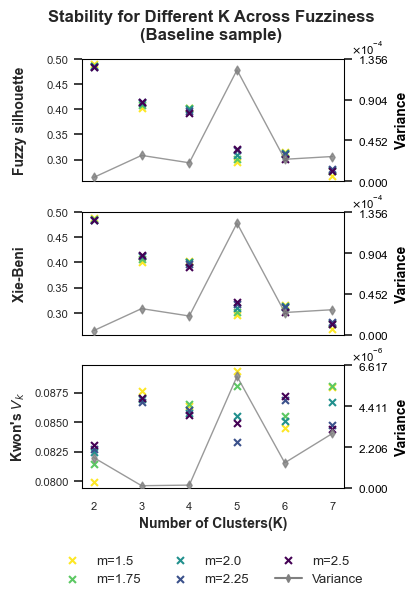

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Read data
history = pd.read_excel(
    '/Users/zhangtongyi/Desktop/P0022024-ËÆ§Áü•ËÅöÁ±ª-project(ÊúÄÊñ∞ÁâàÔºâ/A.ÊúÄÊñ∞ÁâàÊú¨/3.ÊéßÂà∂total PANSS Scores/2.ËÅöÁ±ªÂàÜÊûê-ÊéßÂà∂PANSS total/1.FCM/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /table/fcm_all_resultsÁöÑÂâØÊú¨.xlsx'
)

# Ëá™Âä®ÈÄâÂèñÊâÄÊúâÊï∞ÂÄºÂûãÊåáÊ†áÔºàÊéíÈô§ÂàÜÁªÑÈîÆÔºâ
numeric_cols = history.select_dtypes(include=[np.number]).columns.tolist()
metrics = [col for col in numeric_cols if col not in ['n_clusters', 'fuzziness']]

# ‚Äî‚Äî Âè™‰øùÁïôÂâç‰∏â‰∏™ÊåáÊ†á ‚Äî‚Äî 
metrics = metrics[:3]

# ÊâãÂä®ÊåáÂÆö Y ËΩ¥Ê†áÁ≠æ
metric_labels = ['Fuzzy silhouette', 'Xie-Beni', r"Kwon's $V_k$"]

# ËÆ°ÁÆóÊØè‰∏™ k ÁöÑÊñπÂ∑Æ
var_results = history.groupby('n_clusters')[metrics].var().reset_index()

# Ê†πÊçÆÊåáÊ†áÊï∞ÈáèÂàõÂª∫Â≠êÂõæÔºàÊ≠§Êó∂ num_metrics == 3Ôºâ
num_metrics = len(metrics)
fig, axs = plt.subplots(num_metrics, 1, figsize=(3.5, 5.5), sharex=True)
fig.suptitle('Stability for Different K Across Fuzziness\n(Baseline sample)',
             fontsize=12, fontweight='bold', y=1.02)

# ‰∏çÂêå fuzziness ÂØπÂ∫îÁöÑÈ¢úËâ≤
fuzziness_values = sorted(history['fuzziness'].unique())
colors = plt.cm.viridis_r(np.linspace(0, 1, len(fuzziness_values)))

# Âä®ÊÄÅËÆ°ÁÆóÂêÑÊåáÊ†áÊñπÂ∑ÆËΩ¥ÁöÑËåÉÂõ¥‰∏éÂàªÂ∫¶
var_y_limits = []
var_y_ticks = []
for metric in metrics:
    y_max = var_results[metric].max() * 1.1
    var_y_limits.append((0, y_max))
    var_y_ticks.append(np.linspace(0, y_max, 4).tolist())

# ÁªòÂõæÂæ™ÁéØ
for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
    ax = axs[idx]
    ax_var = ax.twinx()

    # Â∑¶ËΩ¥ÔºöÊÄßËÉΩÊï£ÁÇπ
    for m_idx, m in enumerate(fuzziness_values):
        mask = history['fuzziness'] == m
        ax.scatter(
            history.loc[mask, 'n_clusters'],
            history.loc[mask, metric],
            label=f'm={m}',
            color=colors[m_idx],
            s=25,
            zorder=3,
            marker='x',
            alpha=1
        )

    # Âè≥ËΩ¥ÔºöÊñπÂ∑ÆÊäòÁ∫ø + Êï£ÁÇπ
    ax_var.plot(
        var_results['n_clusters'],
        var_results[metric],
        color='grey',
        linestyle='-',
        linewidth=1,
        alpha=0.8,
        label='Variance'
    )
    ax_var.scatter(
        var_results['n_clusters'],
        var_results[metric],
        color='grey',
        s=20,
        zorder=3,
        alpha=0.8,
        marker='d'
    )

    # ËΩ¥Ê†áÁ≠æ
    ax.set_ylabel(label, fontweight='bold', labelpad=5)
    ax_var.set_ylabel('Variance', fontweight='bold', labelpad=5, color='black')

    # ÂéªÈô§ÊâÄÊúâÁΩëÊ†ºÁ∫ø
    ax.grid(False)
    ax_var.grid(False)

    # ÊñπÂ∑ÆËΩ¥Ê†ºÂºèÂåñ
    ax_var.set_ylim(var_y_limits[idx])
    ax_var.set_yticks(var_y_ticks[idx])
    ax_var.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax_var.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax_var.tick_params(axis='y', labelcolor='black', labelsize=8.5)
    ax_var.yaxis.offsetText.set_position((1.15, 1))
    ax_var.yaxis.offsetText.set_size(8)

    # ÂÖ¨ÂÖ±ÁöÑ x ÂàªÂ∫¶
    ax.set_xticks(sorted(history['n_clusters'].unique()))

    # Âä†Á≤óÂõõÊù°ËæπÊ°ÜÔºåÈªëËâ≤
    for spine in ax.spines.values():
        spine.set_linewidth(0.75)
        spine.set_edgecolor('black')
    for spine in ax_var.spines.values():
        spine.set_linewidth(0.75)
        spine.set_edgecolor('black')

# Â∫ïÈÉ®Â≠êÂõæÊ∑ªÂä† x ËΩ¥Ê†áÁ≠æ
axs[-1].set_xlabel('Number of Clusters(K)', fontweight='bold')

# ÊûÑÂª∫ÂêàÂπ∂Âõæ‰æã
handles, labels = axs[0].get_legend_handles_labels()
variance_handle = plt.Line2D([0], [0], color='grey', linestyle='-', marker='d', markersize=4)
handles.append(variance_handle)
labels.append('Variance')

fig.legend(
    handles, labels,
    bbox_to_anchor=(0.5, 0.05),
    loc='upper center',
    ncol=3,
    frameon=False,
    fontsize=9.5
)

# Ë∞ÉÊï¥Â∏ÉÂ±Ä
fig.align_ylabels(axs)
fig.subplots_adjust(hspace=0.25, top=0.93, bottom=0.15, left=0.13, right=0.88)

# ‰øùÂ≠òÂπ∂Â±ïÁ§∫
plt.savefig('./image/FCM_clustering_analysis.jpg', dpi=1200, bbox_inches='tight')
plt.show()

## 5.subsampleÁ®≥ÂÆöÊÄßÂàÜÊûê

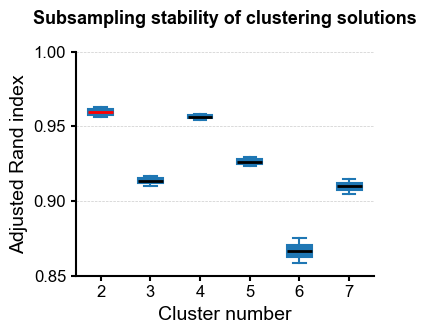

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# ËØªÂèñÊúÄ‰Ω≥ÁªìÊûúÊï∞ÊçÆ
best_results_df = pd.read_pickle('./pkl/fcm_best_results_df.pkl')

# ÊèêÂèñÁ®≥ÂÆöÊÄßÁõ∏ÂÖ≥ÁöÑÂàó
stability_cols = ['stability_sample_mean', 'stability_ci_lower', 'stability_ci_upper']
stability_data = best_results_df[stability_cols]

# ÂàõÂª∫ÂõæÂΩ¢ÂíåÂùêÊ†áËΩ¥
fig, ax = plt.subplots(figsize=(4, 3.5))

# ËÆæÁΩÆÂõæÂΩ¢Ê†∑ÂºèÔºåÂèÇËÄÉ Nature È£éÊ†º
plt.style.use('default')  # ‰ΩøÁî®ÈªòËÆ§Ê†∑Âºè
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['lines.linewidth'] = 2

# Â∞ÜÊï∞ÊçÆËΩ¨Êç¢‰∏∫Ëú°ÁÉõÂõæÈúÄË¶ÅÁöÑÊ†ºÂºè
stability_means = stability_data['stability_sample_mean'].values
stability_lowers = stability_data['stability_ci_lower'].values
stability_uppers = stability_data['stability_ci_upper'].values

# ËÆ°ÁÆóÁÆ±Á∫øÂõæÁöÑ‰∏ä‰∏ãËæπÁïåÂíåÂõõÂàÜ‰ΩçÂå∫Èó¥
box_data = [list([low, mean, upper]) for low, mean, upper in zip(stability_lowers, stability_means, stability_uppers)]

# ÁªòÂà∂ÁÆ±Á∫øÂõæÔºåË∞ÉÊï¥ÁÆ±Â≠êÁöÑÂÆΩÂ∫¶ÔºåÂπ∂Â∞ÜCluster=2ÁöÑÂùáÂÄºÁ∫øÊù°ËÆæÁΩÆ‰∏∫Á∫¢Ëâ≤
for i, (low, mean, upper) in enumerate(zip(stability_lowers, stability_means, stability_uppers), start=1):
    # ËÆæÁΩÆCluster=2ÁöÑÂùáÂÄºÁ∫øÊù°‰∏∫Á∫¢Ëâ≤
    if i == 1:  # Cluster 2
        median_color = 'red'
    else:
        median_color = 'black'
    
    ax.boxplot([[low, mean, upper]], positions=[i], patch_artist=True, showfliers=False, widths=0.5,
               boxprops=dict(facecolor='#1f77b4', color='#1f77b4', linewidth=1.5),
               whiskerprops=dict(color='#1f77b4', linewidth=1.5),
               medianprops=dict(color=median_color, linewidth=2),
               capprops=dict(color='#1f77b4', linewidth=1.5))

# ËÆæÁΩÆÂõæÂΩ¢Ê†áÈ¢òÂíåÂùêÊ†áËΩ¥Ê†áÁ≠æ
ax.set_title('Subsampling stability of clustering solutions', fontsize=13, fontweight='bold', pad=20)
ax.set_xlabel('Cluster number', fontsize=14)
ax.set_ylabel('Adjusted Rand index', fontsize=14)

# ËÆæÁΩÆxËΩ¥ÂàªÂ∫¶
ax.set_xticks(range(1, len(stability_data.index) + 1))
ax.set_xticklabels(stability_data.index, fontsize=12)

# ËÆæÁΩÆyËΩ¥ËåÉÂõ¥
ax.set_ylim(0.85, 1.0)

# Ê∑ªÂä†Ê∞¥Âπ≥ÁΩëÊ†ºÁ∫ø
ax.grid(axis='y', linestyle='--', linewidth=0.5, color='#cccccc')

# ÂéªÈô§È°∂ÈÉ®ÂíåÂè≥‰æßÁöÑËæπÊ°Ü
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ë∞ÉÊï¥Â∏ÉÂ±Ä
plt.tight_layout()

# ‰øùÂ≠ò‰∏∫È´òÂàÜËæ®ÁéáÂõæÁâá
plt.savefig('./image/FCM-stability-Nature.jpg', dpi=1200, bbox_inches='tight', transparent=True)

plt.show()

## 6.ËæìÂá∫ÊúÄ‰Ω≥ËÅöÁ±ªÁªìÊûúÁöÑÈö∂Â±ûÂ∫¶ÂíåËÆ°ÁÆólabel

In [9]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ÊåáÂÆöÊ®°ÂûãË∑ØÂæÑ
model_path = '/Users/zhangtongyi/Desktop/A1ËÆ∫ÊñáÁöÑÊï∞ÊçÆÊñáÊ°£/P0022024-ËÆ§Áü•ËÅöÁ±ª-project(ÊúÄÊñ∞ÁâàÔºâ/1.ÂΩìÂâçÊúÄÊñ∞ÁâàÊú¨ /3.Âü∫Á∫øÊï∞ÊçÆÂàÜÊûê/2.ËÅöÁ±ªÂàÜÊûê-ÊéßÂà∂PANSS total/1.FCM/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /pkl/fcm_best_model_n_clusters_2.pkl'

# Âä†ËΩΩÊ®°Âûã
with open(model_path, 'rb') as f_model:
    fcm_model = pickle.load(f_model)

# 1. ÊâìÂç∞ËÅöÁ±ª‰∏≠ÂøÉÂπ∂Â≠òÂÇ®‰∏∫Excel
centers = fcm_model.centers
print("ËÅöÁ±ª‰∏≠ÂøÉÔºö")
print(centers)

# Â∞ÜËÅöÁ±ª‰∏≠ÂøÉÂ≠òÂÇ®‰∏∫ExcelÊñá‰ª∂
centers_df = pd.DataFrame(centers, columns=['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7'])
centers_df.to_excel("./table/fcm_cluster_centers.xlsx", index=False)
print("ËÅöÁ±ª‰∏≠ÂøÉÂ∑≤Â≠òÂÇ®‰∏∫ fcm_cluster_centers.xlsx")

# 2. ÊâìÂç∞Ë∂ÖÂèÇÊï∞ÁªÑÂêà
print("\nË∂ÖÂèÇÊï∞ÁªÑÂêàÔºö")
fcm_params = {
    'n_clusters': fcm_model.n_clusters,
    'fuzziness': fcm_model.fuzziness,  # ‰øÆÊîπ‰∫ÜËøôÈáå
    'max_iter': fcm_model.max_iter,
    'error': fcm_model.error
}
for param, value in fcm_params.items():
    print(f"{param}: {value}")

# 3. ÊâìÂç∞Èö∂Â±ûÂ∫¶Áü©ÈòµÂπ∂Â≠òÂÇ®‰∏∫Excel
membership_matrix = fcm_model.fcm.u  # ‰øÆÊîπ‰∫ÜËøôÈáå,ËÆøÈóÆ fcm ÁöÑ u Â±ûÊÄß

# Create an ID column
num_participants = membership_matrix.shape[0]  # Assuming the number of participants is the number of rows in the matrix
ids = [f'{i}' for i in range(num_participants)]

# Convert the membership matrix to a DataFrame and add the ID column
membership_df = pd.DataFrame(membership_matrix, columns=[f'Subtype {i+1}' for i in range(fcm_model.n_clusters)])
membership_df.insert(0, 'ID', ids)  # Insert the ID column at the first position

# Add the 'Group' column based on the conditions
conditions = [
    (membership_df['Subtype 1'] >= 0.60),
    (membership_df['Subtype 2'] >= 0.60),
    ((membership_df['Subtype 1'] < 0.60) & (membership_df['Subtype 2'] < 0.60))
]
choices = [1, 2, 3]
membership_df['Group'] = np.select(conditions, choices)

# Save the DataFrame to an Excel file
membership_df.to_excel("./table/fcm_membership_matrix.xlsx", index=False)

print("Èö∂Â±ûÂ∫¶Áü©ÈòµÂ∑≤Â≠òÂÇ®‰∏∫ fcm_membership_matrix.xlsx")

ËÅöÁ±ª‰∏≠ÂøÉÔºö
[[ 8.26045355e-02 -9.74858755e+00  7.57483912e-04  6.63773146e-03
   9.20217487e-02  1.68591289e-01  9.40505682e-02]
 [-5.93344993e-02  9.28213634e+00 -1.23670142e-02 -3.72607709e-03
  -6.97104786e-02 -1.36556879e-01 -8.30787124e-02]]
ËÅöÁ±ª‰∏≠ÂøÉÂ∑≤Â≠òÂÇ®‰∏∫ fcm_cluster_centers.xlsx

Ë∂ÖÂèÇÊï∞ÁªÑÂêàÔºö
n_clusters: 2
fuzziness: 1.5
max_iter: 1000
error: 1e-05
Èö∂Â±ûÂ∫¶Áü©ÈòµÂ∑≤Â≠òÂÇ®‰∏∫ fcm_membership_matrix.xlsx


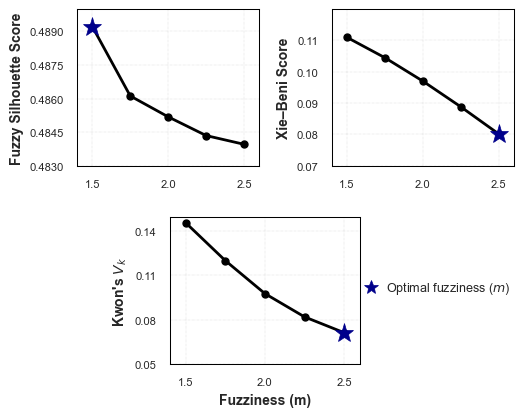

In [10]:
import warnings
from sklearn.base import InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# ========== ÂÖ®Â±ÄÂèØËßÜÂåñÈ£éÊ†º & Â≠ó‰ΩìËÆæÁΩÆ ==========
# Â≠¶ÊúØËÆ∫ÊñáÂ∏∏Áî®Â≠ó‰Ωì‰∏éÁªü‰∏ÄÂ≠óÂè∑
font_family = 'Arial'
FS_LABEL = 10    # ÂùêÊ†áËΩ¥Ê†áÁ≠æÂ≠óÂè∑
FS_TICK = 8      # ÂàªÂ∫¶Ê†áÁ≠æÂ≠óÂè∑
FS_LEGEND = 9    # Âõæ‰æãÂ≠óÂè∑

sns.set(style="whitegrid")
mpl.rcParams.update({
    'font.family': font_family,
    'axes.labelsize': FS_LABEL,
    'axes.titlesize': FS_LABEL,
    'xtick.labelsize': FS_TICK,
    'ytick.labelsize': FS_TICK,
    'legend.fontsize': FS_LEGEND,
    'axes.titleweight': 'normal',
    'axes.linewidth': 1.25,
    'grid.linewidth': 0.3,
    'grid.color': 'gray',
    'grid.alpha': 0.3
})

# ========== Êï∞ÊçÆËØªÂèñ ==========
history = pd.read_excel('./table/fcm_all_resultsÁöÑÂâØÊú¨.xlsx')
best_results_df = pd.read_pickle('./pkl/fcm_best_results_df.pkl')
cluster_2_data = history[history['n_clusters'] == 2]

# ========== ÁªòÂõæÂèÇÊï∞ ==========
color = 'black'
linestyle = '-'
x_values = np.arange(1.25, 2.75, 0.25)

def mark_best_m(ax, cluster_data, metric, max_metric=True):
    idx = (cluster_data[f'mean_{metric}'].idxmax()
           if max_metric else
           cluster_data[f'mean_{metric}'].idxmin())
    m = cluster_data.loc[idx, 'fuzziness']
    score = cluster_data.loc[idx, f'mean_{metric}']
    ax.plot(m, score,
            marker='*',
            markersize=14,
            color='darkblue',
            markeredgewidth=0.5)

# ========== ÂàõÂª∫ÁîªÂ∏É ==========
fig, axes = plt.subplots(2, 2, figsize=(5.4, 4.2))

# ---------- Â≠êÂõæ1ÔºöFuzzy Silhouette Score ----------
ax1 = axes[0, 0]
ax1.plot(cluster_2_data['fuzziness'],
         cluster_2_data['mean_fuzzy_silhouette_score'],
         color=color, linestyle=linestyle, linewidth=2,
         marker='o', markersize=5)
mark_best_m(ax1, cluster_2_data, 'fuzzy_silhouette_score', max_metric=True)
ax1.set_xlim(1.4, 2.6)
ax1.set_xticks([1.5, 2.0, 2.5])
ax1.set_ylim([0.4830, 0.49])
ax1.set_yticks(np.arange(0.4830, 0.49,0.0015)) 
ax1.set_ylabel('Fuzzy Silhouette Score', fontweight='bold')
ax1.grid(which='both', axis='both', linestyle='-.')

# ---------- Â≠êÂõæ2ÔºöXie‚ÄìBeni Score ----------
ax2 = axes[0, 1]
ax2.plot(cluster_2_data['fuzziness'],
         cluster_2_data['mean_xie_beni_score'],
         color=color, linestyle=linestyle, linewidth=2,
         marker='o', markersize=5)
mark_best_m(ax2, cluster_2_data, 'xie_beni_score', max_metric=False)
ax2.set_xlim(1.4, 2.6)
ax2.set_xticks([1.5, 2.0, 2.5])
ax2.set_ylim(0.07, 0.12)
ax2.set_yticks(np.arange(0.07, 0.12, 0.01))
ax2.set_ylabel('Xie‚ÄìBeni Score', fontweight='bold')
ax2.grid(which='both', axis='both', linestyle='-.')

# ÈöêËóèÂ∫ïÈÉ®‰∏§‰∏™Á©∫ÁôΩÁîªÂ∏É
axes[1, 0].axis('off')
axes[1, 1].axis('off')

# ---------- Â≠êÂõæ3ÔºöKwon‚Äôs V‚Çñ ScoreÔºàËá™ÂÆö‰πâ‰ΩçÁΩÆÔºâ ----------
pos = axes[1, 0].get_position()
new_left = pos.x0 + pos.width * 0.58
new_bottom = pos.y0 - pos.height * 0.11
new_width = pos.width
new_height = pos.height
ax3 = fig.add_axes([new_left, new_bottom, new_width, new_height])

ax3.plot(cluster_2_data['fuzziness'],
         cluster_2_data['mean_kwons_v_k_score'],
         color=color, linestyle=linestyle, linewidth=2,
         marker='o', markersize=5)
mark_best_m(ax3, cluster_2_data, 'kwons_v_k_score', max_metric=False)
ax3.set_xlim(1.4, 2.6)
ax3.set_xticks([1.5, 2.0, 2.5])
ax3.set_yticks(np.arange(0.05, 0.1601, 0.03))
ax3.set_xlabel('Fuzziness (m)', fontweight='bold')
ax3.set_ylabel("Kwon's $V_k$", fontweight='bold')
ax3.grid(which='both', axis='both', linestyle='-.')

# ========== ËÆæÁΩÆÊâÄÊúâÂ≠êÂõæÁöÑÂ§ñÊ°Ü‰∏∫ÈªëËâ≤ ==========
for ax in [ax1, ax2, ax3]:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.75)

# ========== Âõæ‰æã & Â∏ÉÂ±Ä ==========
legend_line = mpl.lines.Line2D(
    [0], [0],
    color='darkblue',
    marker='*',
    linestyle='None',
    markersize=10,
    markeredgewidth=0.5,
    label='Optimal fuzziness ($m$)'
)
fig.legend(
    handles=[legend_line],
    loc='upper center',
    bbox_to_anchor=(0.82, 0.3),
    ncol=1,
     handletextpad=0.2,  
    frameon=False
)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig(
    './image/fcm_nature_style_cluster2_plot.jpg',
    dpi=1200,
    bbox_inches='tight',
    transparent=True
)
plt.show()

## 7.PCAÂèØËßÜÂåñÊúÄ‰Ω≥ËÅöÁ±ªÁªìÊûúÂàÜÂ∏É

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import seaborn as sns
import pickle
import pandas as pd

# ËØªÂèñÊï∞ÊçÆ
data = pd.read_excel('../../0.Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜ/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /table/Ê†°Ê≠£Âπ∂Ê†áÂáÜÂåñÂêéÁöÑÊÇ£ËÄÖË°å‰∏∫ÂèòÈáèÊï∞ÊçÆ.xlsx')
EFs_data = data[['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc', 'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']]

# ËØªÂèñ fcm_membership_matrix.xlsx Êñá‰ª∂Âπ∂ÊèêÂèñ Group„ÄÅSubtype 1 Âíå Subtype 2 Âàó
membership_data = pd.read_excel('./table/fcm_membership_matrix.xlsx')
group_data = membership_data['Group']
subtype1_data = membership_data['Subtype 1']
subtype2_data = membership_data['Subtype 2']

# Â∞Ü Group„ÄÅSubtype 1 Âíå Subtype 2 ÂàóÊ∑ªÂä†Âà∞ÂéüÂßãÊï∞ÊçÆ‰∏≠
data['Group'] = group_data
data['Subtype 1'] = subtype1_data
data['Subtype 2'] = subtype2_data

# ‰øùÂ≠òÊõ¥Êñ∞ÂêéÁöÑÊï∞ÊçÆÂà∞Êñ∞ÁöÑ Excel Êñá‰ª∂
updated_data_path = '../../4.Âü∫Á∫øÊï∞ÊçÆÂàÜÊûê-ÊÉ≥Ë¶ÅÂæóÂà∞ÁêÜÊÉ≥ÁªìÊûú/2.ËÅöÁ±ªÂàÜÊûê/1.FCM/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /table/updated_data.xlsx'
data.to_excel(updated_data_path, index=False)

palette = sns.color_palette("deep", 8)

# ÂàùÂßãÂåñËØÑ‰º∞ÊåáÊ†áÂ≠óÂÖ∏
best_params_scores = {
    2: {'best_score': 0.75, 'mean_xie_beni_score': 0.12, 'mean_partition_entropy': 0.9},
    3: {'best_score': 0.72, 'mean_xie_beni_score': 0.15, 'mean_partition_entropy': 0.85},
    # Ê∑ªÂä†ÂÖ∂‰ªñ n_clusters ÁöÑËØÑ‰º∞Êï∞ÊçÆ...
}

# Ëé∑Âèñ‰∏çÂêåËÅöÁ±ªÊï∞Èáè‰∏ãÁöÑÊúÄ‰ºòÊ®°Âûã
best_models = []
for n in range(2, 8):
    with open(f'../../ÂΩìÂâçÊúÄÊñ∞ÁâàÊú¨ /4.Âü∫Á∫øÊï∞ÊçÆÂàÜÊûê-ÊÉ≥Ë¶ÅÂæóÂà∞ÁêÜÊÉ≥ÁªìÊûú/2.ËÅöÁ±ªÂàÜÊûê/1.FCM/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /pkl/fcm_model_n_clusters_{n}_fuzziness_2.5.pkl', 'rb') as f:
        best_model = pickle.load(f)
        best_models.append(best_model)

# ËÆæÁΩÆ‰∏âÁª¥ÂõæÂΩ¢
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111, projection='3d')

# ÈÅçÂéÜÊúÄ‰ºòÊ®°Âûã,ÊâæÂà∞ n_clusters = 2 ÁöÑÊ®°ÂûãÂπ∂ËøõË°åÂèØËßÜÂåñ
for idx, (n_clusters, model) in enumerate(zip(range(2, 8), best_models)):
    if n_clusters == 2:
        # Ëé∑ÂèñËØÑ‰º∞ÊåáÊ†á
        fuzzy_silhouette_score = best_params_scores[n_clusters]['best_score']
        xie_beni_score = best_params_scores[n_clusters]['mean_xie_beni_score']
        partition_entropy = best_params_scores[n_clusters]['mean_partition_entropy']
        
        # Ëé∑ÂèñËÅöÁ±ª‰∏≠ÂøÉÂíåÊ†áÁ≠æ
        fcm_centers = model.centers
        fcm_labels = model.predict(EFs_data)

        # ÂèØËßÜÂåñ‰ª£Á†Å‰øùÊåÅ‰∏çÂèò

        break  # Âè™ÁªòÂà∂ n_clusters = 2 ÁöÑÊ®°Âûã,ÁªòÂà∂ÂÆåÊàêÂêéÈÄÄÂá∫Âæ™ÁéØ


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import seaborn as sns
import pickle
import pandas as pd
from matplotlib.colorbar import ColorbarBase
# ËØªÂèñÊï∞ÊçÆ
data = pd.read_excel('../../0.Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜ/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /table/Ê†°Ê≠£Âπ∂Ê†áÂáÜÂåñÂêéÁöÑÊÇ£ËÄÖË°å‰∏∫ÂèòÈáèÊï∞ÊçÆ.xlsx')
EFs_data = data[['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc', 'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']]

# ËØªÂèñ fcm_membership_matrix.xlsx Êñá‰ª∂Âπ∂ÊèêÂèñ Group„ÄÅSubtype 1 Âíå Subtype 2 Âàó
membership_data = pd.read_excel('./table/fcm_membership_matrix.xlsx')
group_data = membership_data['Group']
subtype1_data = membership_data['Subtype 1']
subtype2_data = membership_data['Subtype 2']

# Â∞Ü Group„ÄÅSubtype 1 Âíå Subtype 2 ÂàóÊ∑ªÂä†Âà∞ÂéüÂßãÊï∞ÊçÆ‰∏≠
data['Group'] = group_data
data['Subtype 1'] = subtype1_data
data['Subtype 2'] = subtype2_data

# ‰øùÂ≠òÊõ¥Êñ∞ÂêéÁöÑÊï∞ÊçÆÂà∞Êñ∞ÁöÑ Excel Êñá‰ª∂
updated_data_path = '../../4.Âü∫Á∫øÊï∞ÊçÆÂàÜÊûê-ÊÉ≥Ë¶ÅÂæóÂà∞ÁêÜÊÉ≥ÁªìÊûú/2.ËÅöÁ±ªÂàÜÊûê/1.FCM/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /table/updated_data.xlsx'
data.to_excel(updated_data_path, index=False)

palette = sns.color_palette("deep", 8)

# Ëé∑Âèñ‰∏çÂêåËÅöÁ±ªÊï∞Èáè‰∏ãÁöÑÊúÄ‰ºòÊ®°Âûã
best_models = []
for n in range(2, 8):
    with open(f'../../4.Âü∫Á∫øÊï∞ÊçÆÂàÜÊûê-ÊÉ≥Ë¶ÅÂæóÂà∞ÁêÜÊÉ≥ÁªìÊûú/2.ËÅöÁ±ªÂàÜÊûê/1.FCM/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /pkl/fcm_model_n_clusters_2_fuzziness_2.5.pkl', 'rb') as f:
        best_model = pickle.load(f)
        best_models.append(best_model)

# ËÆæÁΩÆ‰∏âÁª¥ÂõæÂΩ¢
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111, projection='3d')

# ÈÅçÂéÜÊúÄ‰ºòÊ®°Âûã,ÊâæÂà∞ n_clusters = 2 ÁöÑÊ®°ÂûãÂπ∂ËøõË°åÂèØËßÜÂåñ
for idx, (n_clusters, model) in enumerate(zip(range(2, 8), best_models)):
    if n_clusters == 2:
        # Ëé∑ÂèñËØÑ‰º∞ÊåáÊ†á
        fuzzy_silhouette_score = best_params_scores[n_clusters]['best_score']
        xie_beni_score = best_params_scores[n_clusters]['mean_xie_beni_score']
        partition_entropy = best_params_scores[n_clusters]['mean_partition_entropy']
        
        # Ëé∑ÂèñËÅöÁ±ª‰∏≠ÂøÉÂíåÊ†áÁ≠æ
        fcm_centers = model.centers
        fcm_labels = model.predict(EFs_data)

        # ÂÆö‰πâ Subtype 1 Âíå Subtype 2 ÁöÑÈ¢úËâ≤Êò†Â∞Ñ
        cmap1 = plt.get_cmap('viridis_r')
        cmap2 = plt.get_cmap('inferno_r')

        # ÁªòÂà∂Êï∞ÊçÆÁÇπÂíåËÅöÁ±ª‰∏≠ÂøÉ
        for i in range(n_clusters):
            cluster_points = EFs_data.iloc[fcm_labels == i, [2, 0, 1]]  # Ë∞ÉÊï¥ÂàóÁöÑÈ°∫Â∫è
            
            # ÂàùÂßãÂåñÊâÄÊúâÊï∞ÊçÆÁÇπÁöÑ marker ‰∏∫ 'o'
            markers = ['o'] * len(cluster_points)

            # Ê†πÊçÆ Group Âíå Subtype ÂàóÁöÑÂÄºËÆæÁΩÆÊï∞ÊçÆÁÇπÁöÑÈ¢úËâ≤
            colors = []
            sizes = []
            alpha = []
            edgecolors = []  # Êñ∞Â¢û‰∏Ä‰∏™ÂàóË°®Êù•Â≠òÂÇ®Êï∞ÊçÆÁÇπÁöÑËæπÁºòÈ¢úËâ≤
            for j, (group, subtype1, subtype2) in enumerate(zip(data.loc[fcm_labels == i, 'Group'], data.loc[fcm_labels == i, 'Subtype 1'], data.loc[fcm_labels == i, 'Subtype 2'])):
                if group == 1:
                    colors.append(cmap1(subtype1))
                    sizes.append(70)
                elif group == 2:
                    colors.append(cmap2(subtype2))
                    sizes.append(70)
                elif group == 3:
                    markers[j] = 'X'
                    colors.append('#525252')
                    alpha.append(1.0)
                    edgecolors.append('black')  # ‰∏∫ group 3 ÁöÑÊï∞ÊçÆÁÇπËÆæÁΩÆÁôΩËâ≤ËæπÁºò
                    sizes.append(20)  # ‰∏∫ marker ‰∏∫ 'd' ÁöÑÁÇπËÆæÁΩÆËæÉÂ∞èÁöÑÂ∞∫ÂØ∏
                    
            # ËÆæÁΩÆ Subtype 1 ÁöÑÈ¢úËâ≤Êò†Â∞ÑËåÉÂõ¥
            # ËÆæÁΩÆÈ¢úËâ≤Êò†Â∞ÑÁöÑËåÉÂõ¥
            vmin1 = 0.6  # Ëá™ÂÆö‰πâÁöÑÊúÄÂ∞èÂÄº
            vmax1 = 1.3# Ëá™ÂÆö‰πâÁöÑÊúÄÂ§ßÂÄº


            # ËÆæÁΩÆ Subtype 2 ÁöÑÈ¢úËâ≤Êò†Â∞ÑËåÉÂõ¥
            vmin2 = 0.7 # ÊúÄÂ∞èÂÄº
            vmax2 = 1.2# ÊúÄÂ§ßÂÄº
            
            for j, (marker, point_color, size) in enumerate(zip(markers, colors, sizes)):
                if data.loc[fcm_labels == i, 'Group'].iloc[j] == 1:
                    point_color = cmap1(np.clip((subtype1_data.iloc[fcm_labels == i].iloc[j] - vmin1) / (vmax1 - vmin1), 0, 1))
                elif data.loc[fcm_labels == i, 'Group'].iloc[j] == 2:
                    point_color = cmap2(np.clip((subtype2_data.iloc[fcm_labels == i].iloc[j] - vmin2) / (vmax2 - vmin2), 0, 1))
                
                ax.scatter(cluster_points.iloc[j, 0], cluster_points.iloc[j, 1], cluster_points.iloc[j, 2], alpha=1, label=f'EF subtype {i+1}' if j == 0 else "", color=point_color, edgecolor='none', s=size, marker=marker)

        # ÊâæÂà∞‰Ωç‰∫é‰∏§‰∏™ËÅöÁ±ª‰∫§ÈõÜÂ§ÑÁöÑÊï∞ÊçÆÁÇπ
        intersection_points = EFs_data.iloc[(fcm_labels == 0) & (fcm_labels == 1), [2, 0, 1]]  # Ë∞ÉÊï¥ÂàóÁöÑÈ°∫Â∫è
        
        # ÁªòÂà∂‰Ωç‰∫é‰∏§‰∏™ËÅöÁ±ª‰∫§ÈõÜÂ§ÑÁöÑÊï∞ÊçÆÁÇπ,Âπ∂Â∞ÜÊ†áËÆ∞ËÆæÁΩÆ‰∏∫Á∫¢Ëâ≤ÊñπÂΩ¢
        ax.scatter(intersection_points.iloc[:, 0], intersection_points.iloc[:, 1], intersection_points.iloc[:, 2], alpha=1, color='#525252', edgecolor='none', s=45, marker='X', label='Ambiguous sample')
        # ÁªòÂà∂‰Ωç‰∫é‰∏§‰∏™ËÅöÁ±ª‰∫§ÈõÜÂ§ÑÁöÑÊï∞ÊçÆÁÇπ,Âπ∂Â∞ÜÊ†áËÆ∞ËÆæÁΩÆ‰∏∫Á∫¢Ëâ≤ÊñπÂΩ¢
        ax.scatter(intersection_points.iloc[:, 0], intersection_points.iloc[:, 1], intersection_points.iloc[:, 2], alpha=1, color='black', edgecolor='none', s=65, marker='1', label='Cluster center')
        ax.scatter(fcm_centers[:, 2], fcm_centers[:, 0], fcm_centers[:, 1], marker='1', s=150, c='black', linewidths=2.5, alpha=1, zorder=1,edgecolors='white')
        
        # ËÆæÁΩÆÂõæË°®Ê†áÈ¢òÂíåÊ†áÁ≠æ
        ax.set_title(f'FCM Clustering (n cluster= 2) \n baseline sample', fontsize=14, fontweight='bold', color='black', y=0.85)
        ax.set_xlabel('Dimension 3', fontsize=10, labelpad=10)
        ax.set_ylabel('Dimension 1', fontsize=10, labelpad=10)
        ax.set_zlabel('Dimension 2', fontsize=10, labelpad=3)
        ax.tick_params(axis='both', which='major', labelsize=10)


        # ÂàõÂª∫ Subtype 1 ÁöÑÈ¢úËâ≤Êù°
        ax_cbar1 = fig.add_axes([0.75, 0.26, 0.015, 0.2])  # Ë∞ÉÊï¥È¢úËâ≤Êù°ÁöÑ‰ΩçÁΩÆÂíåÂ§ßÂ∞è
        norm1 = plt.Normalize(vmin=0, vmax=1)  # Â∞ÜÈ¢úËâ≤Êù°ËåÉÂõ¥ËÆæ‰∏∫ 0 Âà∞ 1
        cbar1 = ColorbarBase(ax_cbar1, cmap=cmap1, norm=norm1, orientation='vertical')
        cbar1.set_label('Subtype 1 \n Membership value', fontsize=10)
        cbar1.set_ticks([0, 0.4, 0.8])  # ËÆæÁΩÆÂàªÂ∫¶‰∏∫ 0 Âà∞ 1ÔºåÊ≠•Èïø‰∏∫ 0.4
        cbar1.ax.tick_params(labelsize=8)

        # ÂàõÂª∫ Subtype 2 ÁöÑÈ¢úËâ≤Êù°
        ax_cbar2 = fig.add_axes([0.75, 0.54, 0.015, 0.2])  # Ë∞ÉÊï¥È¢úËâ≤Êù°ÁöÑ‰ΩçÁΩÆÂíåÂ§ßÂ∞è
        norm2 = plt.Normalize(vmin=0, vmax=1)  # Â∞ÜÈ¢úËâ≤Êù°ËåÉÂõ¥ËÆæ‰∏∫ 0 Âà∞ 1
        cbar2 = ColorbarBase(ax_cbar2, cmap=cmap2, norm=norm2, orientation='vertical')
        cbar2.set_label('Subtype 2 \n Membership value', fontsize=10)
        cbar2.set_ticks([0, 0.4, 0.8])  # ËÆæÁΩÆÂàªÂ∫¶‰∏∫ 0 Âà∞ 1ÔºåÊ≠•Èïø‰∏∫ 0.4
        cbar2.ax.tick_params(labelsize=8)

        break  # Âè™ÁªòÂà∂ n_clusters = 2 ÁöÑÊ®°Âûã,ÁªòÂà∂ÂÆåÊàêÂêéÈÄÄÂá∫Âæ™ÁéØ


# ËÆæÁΩÆÂùêÊ†áËΩ¥ÁöÑÂèñÂÄºËåÉÂõ¥ÂíåÂàªÂ∫¶
ax.set_xlim(-7, 1)
ax.set_ylim(-3, 1.5)
ax.set_zlim(-30, 41)
ax.set_xticks(np.arange(-7, 1, 2))
ax.set_yticks(np.arange(-3, 1.5, 1))
ax.set_zticks(np.arange(-30, 41, 10))

# ËÆæÁΩÆÁΩëÊ†ºÁ∫øÁöÑÈ¢úËâ≤ÂíåÁ≤óÁªÜ
ax.xaxis._axinfo["grid"]['color'] = (0.5, 0.5, 0.5, 0.7)
ax.yaxis._axinfo["grid"]['color'] = (0.5, 0.5, 0.5, 0.5)
ax.zaxis._axinfo["grid"]['color'] = (0.5, 0.5, 0.5, 0.5)
ax.xaxis._axinfo["grid"]['linestyle'] = '-'
ax.yaxis._axinfo["grid"]['linestyle'] = '-'
ax.zaxis._axinfo["grid"]['linestyle'] = '-.'
ax.xaxis._axinfo["grid"]['linewidth'] = 0.8
ax.yaxis._axinfo["grid"]['linewidth'] = 0.8
ax.zaxis._axinfo["grid"]['linewidth'] = 0.8

# Ë∞ÉÊï¥Âõæ‰æã‰ΩçÁΩÆ
ax.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.5,0.12), ncol=4, frameon=False)

# Ë∞ÉÊï¥Â∏ÉÂ±Ä‰ª•Ëé∑ÂæóÊõ¥Â•ΩÁöÑÈó¥Ë∑ù
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ë∞ÉÊï¥ rect ÂÄº‰ª•ÊéßÂà∂ËæπË∑ù

# Ë∞ÉÊï¥ËßÜËßí
ax.view_init(elev=0.5, azim=18)  # ‰ª∞Ëßí‰∏∫ 20 Â∫¶,Êñπ‰ΩçËßí‰∏∫ 45 Â∫¶

# Âú®Âè¶‰∏Ä‰æßÊ∑ªÂä†‰∏ÄÊù°Á∫øË°®Á§∫ Y ËΩ¥,‰ΩÜÊ≤°ÊúâÂùêÊ†áÂíåÊ†áÊ≥®
y_min, y_max = ax.get_ylim()
z_min, z_max = ax.get_zlim()
x_max, x_min = ax.get_xlim()
ax.plot([x_max, x_max], [y_min, y_max], [z_max, z_max], 'k-', linewidth=0.5, color='black')

# Ëé∑Âèñ x, y, z ËΩ¥ÁöÑÊúÄÂ∞èÂíåÊúÄÂ§ßÂÄº
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
z_min, z_max = ax.get_zlim()

# ÂÆö‰πâÁ´ãÊñπ‰ΩìÁöÑÈ°∂ÁÇπÂùêÊ†á
vertices = np.array([
    [x_min, y_min, z_min],
    [x_max, y_min, z_min],
    [x_max, y_max, z_min],
    [x_min, y_max, z_min],
    [x_min, y_min, z_max],
    [x_max, y_min, z_max],
    [x_max, y_max, z_max],
    [x_min, y_max, z_max]
])

# ÂÆö‰πâÁ´ãÊñπ‰ΩìÁöÑÈù¢
faces = [
    [vertices[0], vertices[1], vertices[2], vertices[3]],  # Â∫ïÈù¢
    [vertices[4], vertices[5], vertices[6], vertices[7]],  # È°∂Èù¢
    [vertices[0], vertices[1], vertices[5], vertices[4]],  # ÂâçÈù¢
    [vertices[2], vertices[3], vertices[7], vertices[6]],  # ÂêéÈù¢
    [vertices[1], vertices[2], vertices[6], vertices[5]],  # Âè≥‰æßÈù¢
    [vertices[4], vertices[7], vertices[3], vertices[0]]   # Â∑¶‰æßÈù¢
]

# ÁªòÂà∂Á´ãÊñπ‰ΩìÁöÑÊ£±
for i in range(4):
    # ÁªòÂà∂Â∫ïÈù¢ÁöÑÊ£±
    ax.plot(
        [vertices[i,0], vertices[(i+1)%4,0]],           # Ê£±ÁöÑËµ∑ÁÇπÂíåÁªàÁÇπÁöÑ x ÂùêÊ†á
        [vertices[i,1], vertices[(i+1)%4,1]],           # Ê£±ÁöÑËµ∑ÁÇπÂíåÁªàÁÇπÁöÑ y ÂùêÊ†á
        [vertices[i,2], vertices[(i+1)%4,2]],           # Ê£±ÁöÑËµ∑ÁÇπÂíåÁªàÁÇπÁöÑ z ÂùêÊ†á
        'black',                                        # Ê£±ÁöÑÈ¢úËâ≤
        linewidth=0.5                                     # Ê£±ÁöÑÁ∫øÂÆΩ
    )
    

    if i not in [1, 2]:  # ‰∏çÁªòÂà∂Âè≥‰æßÈù¢ÂíåÂêé‰æßÈù¢ÁöÑÈ°∂Ê£±
        ax.plot(
            [vertices[i+4,0], vertices[(i+1)%4+4,0]],       # Ê£±ÁöÑËµ∑ÁÇπÂíåÁªàÁÇπÁöÑ x ÂùêÊ†á
            [vertices[i+4,1], vertices[(i+1)%4+4,1]],       # Ê£±ÁöÑËµ∑ÁÇπÂíåÁªàÁÇπÁöÑ y ÂùêÊ†á
            [vertices[i+4,2], vertices[(i+1)%4+4,2]],       # Ê£±ÁöÑËµ∑ÁÇπÂíåÁªàÁÇπÁöÑ z ÂùêÊ†á
            'black',                                        # Ê£±ÁöÑÈ¢úËâ≤
            linewidth=0.8                                    # Ê£±ÁöÑÁ∫øÂÆΩ
        )

    # ÁªòÂà∂ËøûÊé•È°∂Èù¢ÂíåÂ∫ïÈù¢ÁöÑÁ´ñÊ£±
    if i != 2:  # ‰∏çÁªòÂà∂Âè≥‰æßÈù¢ÁöÑÁ´ñÊ£±
        ax.plot(
            [vertices[i,0], vertices[i+4,0]],               # Ê£±ÁöÑËµ∑ÁÇπÂíåÁªàÁÇπÁöÑ x ÂùêÊ†á
            [vertices[i,1], vertices[i+4,1]],               # Ê£±ÁöÑËµ∑ÁÇπÂíåÁªàÁÇπÁöÑ y ÂùêÊ†á
            [vertices[i,2], vertices[i+4,2]],               # Ê£±ÁöÑËµ∑ÁÇπÂíåÁªàÁÇπÁöÑ z ÂùêÊ†á
            'black',                                        # Ê£±ÁöÑÈ¢úËâ≤
            linewidth=0.8                                   # Ê£±ÁöÑÁ∫øÂÆΩ
        )
        
# ‰øùÂ≠ò‰∏∫È´òÂàÜËæ®ÁéáÂõæÂÉè
plt.savefig('./image/FCMËÅöÁ±ªÂèØËßÜÂåñ_Cluster2baseline sample_3D_with_hyperplane_axis_swapped_bold_edges.jpg', dpi=1200, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import seaborn as sns
import pickle
import pandas as pd

# ËØªÂèñÊï∞ÊçÆ
data = pd.read_excel('../../4.Âü∫Á∫øÊï∞ÊçÆÂàÜÊûê-ÊÉ≥Ë¶ÅÂæóÂà∞ÁêÜÊÉ≥ÁªìÊûú/2.ËÅöÁ±ªÂàÜÊûê/0.Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜ/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /table/Ê†°Ê≠£Âπ∂Ê†áÂáÜÂåñÂêéÁöÑÊÇ£ËÄÖË°å‰∏∫ÂèòÈáèÊï∞ÊçÆ.xlsx')
EFs_data = data[['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc', 'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']]

# ËØªÂèñ fcm_membership_matrix.xlsx Êñá‰ª∂Âπ∂ÊèêÂèñ Group„ÄÅSubtype 1 Âíå Subtype 2 Âàó
membership_data = pd.read_excel('./table/fcm_membership_matrix.xlsx')
group_data = membership_data['Group']
subtype1_data = membership_data['Subtype 1']
subtype2_data = membership_data['Subtype 2']

# Â∞Ü Group„ÄÅSubtype 1 Âíå Subtype 2 ÂàóÊ∑ªÂä†Âà∞ÂéüÂßãÊï∞ÊçÆ‰∏≠
data['Group'] = group_data
data['Subtype 1'] = subtype1_data
data['Subtype 2'] = subtype2_data

# ‰øùÂ≠òÊõ¥Êñ∞ÂêéÁöÑÊï∞ÊçÆÂà∞Êñ∞ÁöÑ Excel Êñá‰ª∂
updated_data_path = '../../4.Âü∫Á∫øÊï∞ÊçÆÂàÜÊûê-ÊÉ≥Ë¶ÅÂæóÂà∞ÁêÜÊÉ≥ÁªìÊûú/2.ËÅöÁ±ªÂàÜÊûê/0.Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜ/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /table/updated_data.xlsx'
data.to_excel(updated_data_path, index=False)

palette = sns.color_palette("deep", 8)

# Ëé∑Âèñ‰∏çÂêåËÅöÁ±ªÊï∞Èáè‰∏ãÁöÑÊúÄ‰ºòÊ®°Âûã
best_models = []
for n in range(2, 8):
    with open(f'../../4.Âü∫Á∫øÊï∞ÊçÆÂàÜÊûê-ÊÉ≥Ë¶ÅÂæóÂà∞ÁêÜÊÉ≥ÁªìÊûú/2.ËÅöÁ±ªÂàÜÊûê/1.FCM/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /pkl/fcm_model_n_clusters_2_fuzziness_2.5.pkl', 'rb') as f:
        best_model = pickle.load(f)
        best_models.append(best_model)

# ËÆæÁΩÆ‰∏âÁª¥ÂõæÂΩ¢
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111, projection='3d')

# ÈÅçÂéÜÊúÄ‰ºòÊ®°Âûã,ÊâæÂà∞ n_clusters = 2 ÁöÑÊ®°ÂûãÂπ∂ËøõË°åÂèØËßÜÂåñ
for idx, (n_clusters, model) in enumerate(zip(range(2, 8), best_models)):
    if n_clusters == 2:
        # Ëé∑ÂèñËØÑ‰º∞ÊåáÊ†á
        fuzzy_silhouette_score = best_params_scores[n_clusters]['best_score']
        xie_beni_score = best_params_scores[n_clusters]['mean_xie_beni_score']
        partition_entropy = best_params_scores[n_clusters]['mean_partition_entropy']
        
        # Ëé∑ÂèñËÅöÁ±ª‰∏≠ÂøÉÂíåÊ†áÁ≠æ  
        fcm_centers = model.centers
        fcm_labels = model.predict(EFs_data)

        # ÂÆö‰πâ Subtype 1 Âíå Subtype 2 ÁöÑÈ¢úËâ≤Êò†Â∞Ñ
        cmap1 = plt.get_cmap('viridis_r')
        cmap2 = plt.get_cmap('inferno_r')

        # ÁªòÂà∂Êï∞ÊçÆÁÇπÂíåËÅöÁ±ª‰∏≠ÂøÉ
        for i in range(n_clusters):
            cluster_points = EFs_data.iloc[fcm_labels == i, [2, 0, 1]]  # Ë∞ÉÊï¥ÂàóÁöÑÈ°∫Â∫è
            
            # ÂàùÂßãÂåñÊâÄÊúâÊï∞ÊçÆÁÇπÁöÑ marker ‰∏∫ 'o'
            markers = ['o'] * len(cluster_points)

            # Ê†πÊçÆ Group Âíå Subtype ÂàóÁöÑÂÄºËÆæÁΩÆÊï∞ÊçÆÁÇπÁöÑÈ¢úËâ≤
            colors = []
            sizes = []
            alpha = []
            edgecolors = []  # Êñ∞Â¢û‰∏Ä‰∏™ÂàóË°®Êù•Â≠òÂÇ®Êï∞ÊçÆÁÇπÁöÑËæπÁºòÈ¢úËâ≤
            for j, (group, subtype1, subtype2) in enumerate(zip(data.loc[fcm_labels == i, 'Group'], data.loc[fcm_labels == i, 'Subtype 1'], data.loc[fcm_labels == i, 'Subtype 2'])):
                if group == 1:
                    colors.append(cmap1(subtype1))
                    sizes.append(70)
                elif group == 2:
                    colors.append(cmap2(subtype2))
                    sizes.append(70)
                elif group == 3:
                    markers[j] = 'X'
                    colors.append('#525252')
                    alpha.append(1.0)
                    edgecolors.append('black')  # ‰∏∫ group 3 ÁöÑÊï∞ÊçÆÁÇπËÆæÁΩÆÁôΩËâ≤ËæπÁºò
                    sizes.append(20)  # ‰∏∫ marker ‰∏∫ 'd' ÁöÑÁÇπËÆæÁΩÆËæÉÂ∞èÁöÑÂ∞∫ÂØ∏
                    
            # ËÆæÁΩÆ Subtype 1 ÁöÑÈ¢úËâ≤Êò†Â∞ÑËåÉÂõ¥
            # ËÆæÁΩÆÈ¢úËâ≤Êò†Â∞ÑÁöÑËåÉÂõ¥
            vmin1 = 0.6  # Ëá™ÂÆö‰πâÁöÑÊúÄÂ∞èÂÄº
            vmax1 = 1.3# Ëá™ÂÆö‰πâÁöÑÊúÄÂ§ßÂÄº


            # ËÆæÁΩÆ Subtype 2 ÁöÑÈ¢úËâ≤Êò†Â∞ÑËåÉÂõ¥
            vmin2 = 0.7 # ÊúÄÂ∞èÂÄº
            vmax2 = 1.2# ÊúÄÂ§ßÂÄº
            
            for j, (marker, point_color, size) in enumerate(zip(markers, colors, sizes)):
                if data.loc[fcm_labels == i, 'Group'].iloc[j] == 1:
                    point_color = cmap1(np.clip((subtype1_data.iloc[fcm_labels == i].iloc[j] - vmin1) / (vmax1 - vmin1), 0, 1))
                elif data.loc[fcm_labels == i, 'Group'].iloc[j] == 2:
                    point_color = cmap2(np.clip((subtype2_data.iloc[fcm_labels == i].iloc[j] - vmin2) / (vmax2 - vmin2), 0, 1))
                
                ax.scatter(cluster_points.iloc[j, 0], cluster_points.iloc[j, 1], cluster_points.iloc[j, 2], alpha=1, label=f'EF subtype {i+1}' if j == 0 else "", color=point_color, edgecolor='none', s=size, marker=marker)

        # ÊâæÂà∞‰Ωç‰∫é‰∏§‰∏™ËÅöÁ±ª‰∫§ÈõÜÂ§ÑÁöÑÊï∞ÊçÆÁÇπ
        intersection_points = EFs_data.iloc[(fcm_labels == 0) & (fcm_labels == 1), [2, 0, 1]]  # Ë∞ÉÊï¥ÂàóÁöÑÈ°∫Â∫è
        
        # ÁªòÂà∂‰Ωç‰∫é‰∏§‰∏™ËÅöÁ±ª‰∫§ÈõÜÂ§ÑÁöÑÊï∞ÊçÆÁÇπ,Âπ∂Â∞ÜÊ†áËÆ∞ËÆæÁΩÆ‰∏∫Á∫¢Ëâ≤ÊñπÂΩ¢
        ax.scatter(intersection_points.iloc[:, 0], intersection_points.iloc[:, 1], intersection_points.iloc[:, 2], alpha=1, color='#525252', edgecolor='none', s=45, marker='X', label='Ambiguous sample')
        # ÁªòÂà∂‰Ωç‰∫é‰∏§‰∏™ËÅöÁ±ª‰∫§ÈõÜÂ§ÑÁöÑÊï∞ÊçÆÁÇπ,Âπ∂Â∞ÜÊ†áËÆ∞ËÆæÁΩÆ‰∏∫Á∫¢Ëâ≤ÊñπÂΩ¢
        ax.scatter(intersection_points.iloc[:, 0], intersection_points.iloc[:, 1], intersection_points.iloc[:, 2], alpha=1, color='black', edgecolor='none', s=65, marker='1', label='Cluster center')
        ax.scatter(fcm_centers[:, 2], fcm_centers[:, 0], fcm_centers[:, 1], marker='1', s=150, c='black', linewidths=2.5, alpha=1, zorder=1,edgecolors='white')
        
        break  # Âè™ÁªòÂà∂ n_clusters = 2 ÁöÑÊ®°Âûã,ÁªòÂà∂ÂÆåÊàêÂêéÈÄÄÂá∫Âæ™ÁéØ

# ÂéªÊéâÂùêÊ†áËΩ¥ÂíåÂàªÂ∫¶
ax.set_axis_off()

# Ë∞ÉÊï¥Âõæ‰æã‰ΩçÁΩÆ
ax.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.35,0.3), ncol=2, frameon=False)

# Ë∞ÉÊï¥Â∏ÉÂ±Ä‰ª•Ëé∑ÂæóÊõ¥Â•ΩÁöÑÈó¥Ë∑ù
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ë∞ÉÊï¥ rect ÂÄº‰ª•ÊéßÂà∂ËæπË∑ù

# Ë∞ÉÊï¥ËßÜËßí
ax.view_init(elev=0.5, azim=18)  # ‰ª∞Ëßí‰∏∫ 20 Â∫¶,Êñπ‰ΩçËßí‰∏∫ 45 Â∫¶

# ‰øùÂ≠ò‰∏∫È´òÂàÜËæ®ÁéáÂõæÂÉè
plt.savefig('./image/FCMËÅöÁ±ªÂèØËßÜÂåñ_Cluster2baseline sample_3D_no_axes_legend_only.jpg', dpi=2000, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import seaborn as sns
import pickle
import pandas as pd

# ËØªÂèñÊï∞ÊçÆ
data = pd.read_excel('../../4.Âü∫Á∫øÊï∞ÊçÆÂàÜÊûê-ÊÉ≥Ë¶ÅÂæóÂà∞ÁêÜÊÉ≥ÁªìÊûú/2.ËÅöÁ±ªÂàÜÊûê/0.Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜ/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /table/Ê†°Ê≠£Âπ∂Ê†áÂáÜÂåñÂêéÁöÑÊÇ£ËÄÖË°å‰∏∫ÂèòÈáèÊï∞ÊçÆ.xlsx')
EFs_data = data[['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc', 'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']]

# ËØªÂèñ fcm_membership_matrix.xlsx Êñá‰ª∂Âπ∂ÊèêÂèñ Group„ÄÅSubtype 1 Âíå Subtype 2 Âàó
membership_data = pd.read_excel('./table/fcm_membership_matrix.xlsx')
group_data = membership_data['Group']
subtype1_data = membership_data['Subtype 1']
subtype2_data = membership_data['Subtype 2']

# Â∞Ü Group„ÄÅSubtype 1 Âíå Subtype 2 ÂàóÊ∑ªÂä†Âà∞ÂéüÂßãÊï∞ÊçÆ‰∏≠
data['Group'] = group_data
data['Subtype 1'] = subtype1_data
data['Subtype 2'] = subtype2_data

# ‰øùÂ≠òÊõ¥Êñ∞ÂêéÁöÑÊï∞ÊçÆÂà∞Êñ∞ÁöÑ Excel Êñá‰ª∂
updated_data_path = '../../4.Âü∫Á∫øÊï∞ÊçÆÂàÜÊûê-ÊÉ≥Ë¶ÅÂæóÂà∞ÁêÜÊÉ≥ÁªìÊûú/2.ËÅöÁ±ªÂàÜÊûê/0.Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜ/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /table/updated_data.xlsx'
data.to_excel(updated_data_path, index=False)

palette = sns.color_palette("deep", 8)

# Ëé∑Âèñ‰∏çÂêåËÅöÁ±ªÊï∞Èáè‰∏ãÁöÑÊúÄ‰ºòÊ®°Âûã
best_models = []
for n in range(2, 8):
    with open(f'../../4.Âü∫Á∫øÊï∞ÊçÆÂàÜÊûê-ÊÉ≥Ë¶ÅÂæóÂà∞ÁêÜÊÉ≥ÁªìÊûú/2.ËÅöÁ±ªÂàÜÊûê/1.FCM/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /pkl/fcm_model_n_clusters_2_fuzziness_2.5.pkl', 'rb') as f:
        best_model = pickle.load(f)
        best_models.append(best_model)

# ËÆæÁΩÆ‰∏âÁª¥ÂõæÂΩ¢
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111, projection='3d')

# ÈÅçÂéÜÊúÄ‰ºòÊ®°Âûã,ÊâæÂà∞ n_clusters = 2 ÁöÑÊ®°ÂûãÂπ∂ËøõË°åÂèØËßÜÂåñ
for idx, (n_clusters, model) in enumerate(zip(range(2, 8), best_models)):
    if n_clusters == 2:
        # Ëé∑ÂèñËØÑ‰º∞ÊåáÊ†á
        fuzzy_silhouette_score = best_params_scores[n_clusters]['best_score']
        xie_beni_score = best_params_scores[n_clusters]['mean_xie_beni_score']
        partition_entropy = best_params_scores[n_clusters]['mean_partition_entropy']
        
        # Ëé∑ÂèñËÅöÁ±ª‰∏≠ÂøÉÂíåÊ†áÁ≠æ  
        fcm_centers = model.centers
        fcm_labels = model.predict(EFs_data)

        # ÂÆö‰πâ Subtype 1 Âíå Subtype 2 ÁöÑÈ¢úËâ≤Êò†Â∞Ñ
        cmap1 = plt.get_cmap('viridis_r')
        cmap2 = plt.get_cmap('inferno_r')

        # ÁªòÂà∂Êï∞ÊçÆÁÇπÂíåËÅöÁ±ª‰∏≠ÂøÉ
        for i in range(n_clusters):
            cluster_points = EFs_data.iloc[fcm_labels == i, [2, 0, 1]]  # Ë∞ÉÊï¥ÂàóÁöÑÈ°∫Â∫è
            
            # ÂàùÂßãÂåñÊâÄÊúâÊï∞ÊçÆÁÇπÁöÑ marker ‰∏∫ 'o'
            markers = ['o'] * len(cluster_points)

            # Ê†πÊçÆ Group Âíå Subtype ÂàóÁöÑÂÄºËÆæÁΩÆÊï∞ÊçÆÁÇπÁöÑÈ¢úËâ≤
            colors = []
            sizes = []
            alpha = []
            edgecolors = []  # Êñ∞Â¢û‰∏Ä‰∏™ÂàóË°®Êù•Â≠òÂÇ®Êï∞ÊçÆÁÇπÁöÑËæπÁºòÈ¢úËâ≤
            for j, (group, subtype1, subtype2) in enumerate(zip(data.loc[fcm_labels == i, 'Group'], data.loc[fcm_labels == i, 'Subtype 1'], data.loc[fcm_labels == i, 'Subtype 2'])):
                if group == 1:
                    colors.append(cmap1(subtype1))
                    sizes.append(70)
                elif group == 2:
                    colors.append(cmap2(subtype2))
                    sizes.append(70)
                elif group == 3:
                    markers[j] = 'X'
                    colors.append('none')
                    alpha.append(1.0)
                    edgecolors.append('none')  # ‰∏∫ group 3 ÁöÑÊï∞ÊçÆÁÇπËÆæÁΩÆÁôΩËâ≤ËæπÁºò
                    sizes.append(1)  # ‰∏∫ marker ‰∏∫ 'd' ÁöÑÁÇπËÆæÁΩÆËæÉÂ∞èÁöÑÂ∞∫ÂØ∏
                    
            # ËÆæÁΩÆ Subtype 1 ÁöÑÈ¢úËâ≤Êò†Â∞ÑËåÉÂõ¥
            # ËÆæÁΩÆÈ¢úËâ≤Êò†Â∞ÑÁöÑËåÉÂõ¥
            vmin1 = 0.6  # Ëá™ÂÆö‰πâÁöÑÊúÄÂ∞èÂÄº
            vmax1 = 1.3# Ëá™ÂÆö‰πâÁöÑÊúÄÂ§ßÂÄº


            # ËÆæÁΩÆ Subtype 2 ÁöÑÈ¢úËâ≤Êò†Â∞ÑËåÉÂõ¥
            vmin2 = 0.7 # ÊúÄÂ∞èÂÄº
            vmax2 = 1.2# ÊúÄÂ§ßÂÄº
            
            for j, (marker, point_color, size) in enumerate(zip(markers, colors, sizes)):
                if data.loc[fcm_labels == i, 'Group'].iloc[j] == 1:
                    point_color = cmap1(np.clip((subtype1_data.iloc[fcm_labels == i].iloc[j] - vmin1) / (vmax1 - vmin1), 0, 1))
                elif data.loc[fcm_labels == i, 'Group'].iloc[j] == 2:
                    point_color = cmap2(np.clip((subtype2_data.iloc[fcm_labels == i].iloc[j] - vmin2) / (vmax2 - vmin2), 0, 1))
                
                ax.scatter(cluster_points.iloc[j, 0], cluster_points.iloc[j, 1], cluster_points.iloc[j, 2], alpha=1, label=f'EF subtype {i+1}' if j == 0 else "", color=point_color, edgecolor='none', s=size, marker=marker)

        # ÊâæÂà∞‰Ωç‰∫é‰∏§‰∏™ËÅöÁ±ª‰∫§ÈõÜÂ§ÑÁöÑÊï∞ÊçÆÁÇπ
        intersection_points = EFs_data.iloc[(fcm_labels == 0) & (fcm_labels == 1), [2, 0, 1]]  # Ë∞ÉÊï¥ÂàóÁöÑÈ°∫Â∫è
        
        # ÁªòÂà∂‰Ωç‰∫é‰∏§‰∏™ËÅöÁ±ª‰∫§ÈõÜÂ§ÑÁöÑÊï∞ÊçÆÁÇπ,Âπ∂Â∞ÜÊ†áËÆ∞ËÆæÁΩÆ‰∏∫Á∫¢Ëâ≤ÊñπÂΩ¢
        ax.scatter(intersection_points.iloc[:, 0], intersection_points.iloc[:, 1], intersection_points.iloc[:, 2], alpha=1, color='#525252', edgecolor='none', s=45, marker='X', label='Ambiguous sample')
        # ÁªòÂà∂‰Ωç‰∫é‰∏§‰∏™ËÅöÁ±ª‰∫§ÈõÜÂ§ÑÁöÑÊï∞ÊçÆÁÇπ,Âπ∂Â∞ÜÊ†áËÆ∞ËÆæÁΩÆ‰∏∫Á∫¢Ëâ≤ÊñπÂΩ¢
        ax.scatter(intersection_points.iloc[:, 0], intersection_points.iloc[:, 1], intersection_points.iloc[:, 2], alpha=1, color='black', edgecolor='none', s=65, marker='1', label='Cluster center')
        ax.scatter(fcm_centers[:, 2], fcm_centers[:, 0], fcm_centers[:, 1], marker='1', s=150, c='none', linewidths=2.5, alpha=1, zorder=1,edgecolors='white')
        
        break  # Âè™ÁªòÂà∂ n_clusters = 2 ÁöÑÊ®°Âûã,ÁªòÂà∂ÂÆåÊàêÂêéÈÄÄÂá∫Âæ™ÁéØ

# ÂéªÊéâÂùêÊ†áËΩ¥ÂíåÂàªÂ∫¶
ax.set_axis_off()

# Ë∞ÉÊï¥Â∏ÉÂ±Ä‰ª•Ëé∑ÂæóÊõ¥Â•ΩÁöÑÈó¥Ë∑ù
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ë∞ÉÊï¥ rect ÂÄº‰ª•ÊéßÂà∂ËæπË∑ù

# Ë∞ÉÊï¥ËßÜËßí
ax.view_init(elev=0.5, azim=18)  # ‰ª∞Ëßí‰∏∫ 20 Â∫¶,Êñπ‰ΩçËßí‰∏∫ 45 Â∫¶

# ‰øùÂ≠ò‰∏∫È´òÂàÜËæ®ÁéáÂõæÂÉè
plt.savefig('./image/FCMËÅöÁ±ªÂèØËßÜÂåñ_Cluster2baseline sample_3D_no_axes_legend_only222.jpg', dpi=2000, bbox_inches='tight')
plt.show()

## 8.ÊâÄÊúâËÅöÁ±ªclusterÁöÑÊ†∑Êú¨ÂàÜÂ∏É

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import seaborn as sns
import pickle

# ËÆæÁΩÆÁ¨¶ÂêàNatureÊ†áÂáÜÁöÑË∞ÉËâ≤Êùø
palette = sns.color_palette("deep", 8)

# Ëé∑Âèñ‰∏çÂêåËÅöÁ±ªÊï∞Èáè‰∏ãÁöÑÊúÄ‰ºòÊ®°Âûã
best_models = []
for n in range(2, 8):
    with open(f'./pkl/fcm_model_n_clusters_{n}_fuzziness_2.25.pkl', 'rb') as f:
        best_model = pickle.load(f)
        best_models.append(best_model)

# ËÆæÁΩÆÂ≠êÂõæÂ∏ÉÂ±ÄÔºöÊØèË°å3‰∏™ÔºåÊÄªÂÖ±2Ë°å
fig, axes = plt.subplots(2, 3, figsize=(15, 7.5))

# ÈÅçÂéÜÊØè‰∏™ÊúÄ‰ºòÊ®°ÂûãËøõË°åÂèØËßÜÂåñ
for idx, (n_clusters, model, ax) in enumerate(zip(range(2, 8), best_models, axes.ravel())):
    # Ëé∑ÂèñËØÑ‰º∞ÊåáÊ†á
    fuzzy_silhouette_score = best_params_scores[n_clusters]['best_score']
    xie_beni_score = best_params_scores[n_clusters]['mean_xie_beni_score']
    partition_entropy = best_params_scores[n_clusters]['mean_partition_entropy']
    
    # Ëé∑ÂèñËÅöÁ±ª‰∏≠ÂøÉÂíåÊ†áÁ≠æ
    fcm_centers = model.centers
    fcm_labels = model.predict(EFs_data)
    
    # ÁªòÂà∂Êï∞ÊçÆÁÇπÂíåËÅöÁ±ª‰∏≠ÂøÉ
    for i in range(n_clusters):
        cluster_points = EFs_data.iloc[fcm_labels == i, :2]
        color = palette[i % len(palette)]
        ax.scatter(cluster_points.iloc[:, 0], cluster_points.iloc[:, 1], alpha=0.95, label=f'Cluster {i+1}', color=color, edgecolor='none', s=80, marker='o')
        
        # ËÆ°ÁÆóÊ§≠ÂúÜÂèÇÊï∞ÔºåÂπ∂Â¢ûÂä†Âõ†Â≠ê‰ΩøÊ§≠ÂúÜÂåÖÂõ¥Êõ¥Â§öÊï∞ÊçÆÁÇπ
        cov = np.cov(cluster_points, rowvar=False)
        mean = np.mean(cluster_points, axis=0)
        eigvals, eigvecs = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
        factor = 2.1 # Ë∞ÉÊï¥Âõ†Â≠êÔºåÂ¢ûÂä†Ê§≠ÂúÜÁöÑÂ§ßÂ∞è
        width, height = factor * 1.6 * np.sqrt(eigvals)
        
        # Ë∞ÉÊï¥alphaÂÄºÂπ∂Â∞ÜËæπÊ°ÜËÆæÁΩÆ‰∏∫ÈªëËâ≤
        alpha_value = 0.3 if idx < 3 else 0.5
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='black', fc=color, alpha=0.5, lw=1.5, linestyle='--')
        ax.add_patch(ellipse)
    
    ax.scatter(fcm_centers[:, 0], fcm_centers[:, 1], marker='1', s=250, c='red', linewidths=1.5)
    
    # ËÆæÁΩÆÂõæË°®Ê†áÈ¢òÂíåÊ†áÁ≠æ
    ax.set_title(f'n clusters = {n_clusters}', fontsize=14, fontweight='bold')
    if idx >= 3:  # ‰ªÖ‰∏∫Á¨¨‰∫åË°åÁöÑÂõæÊ∑ªÂä†XËΩ¥Ê†áÁ≠æ
        ax.set_xlabel('Dimension 1', fontsize=12)
    ax.set_ylabel('Dimension 2', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.legend(fontsize=9)

# Âà†Èô§Â§ö‰ΩôÁöÑÂ≠êÂõæÊ°ÜÊû∂ÔºàÂ¶ÇÊûúÂ≠êÂõæÊï∞Èáè‰∏çÊª°Ôºâ
for ax in axes.ravel()[len(best_models):]:
    ax.remove()

# Ê∑ªÂä†ÊÄªÊ†áÈ¢ò
plt.suptitle('FCM Clustering Visualization(Baseline sample)', fontsize=16, fontweight='bold', y=0.92)

# Ë∞ÉÊï¥Â≠êÂõæÈó¥Ë∑ù
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save as high-resolution image
plt.savefig('./image/FCMËÅöÁ±ªÂèØËßÜÂåñ.jpg', dpi=1200, bbox_inches='tight')
plt.show()

## 9.ÈöèËÆøÁ®≥ÂÆöÊÄßÊ£ÄÈ™å

In [ ]:
import pandas as pd
import numpy as np
import pickle
from scipy.spatial.distance import cdist

# ËØªÂèñÈöèËÆøÊ†∑Êú¨Êï∞ÊçÆ
followup_data = pd.read_excel('/Users/zhangtongyi/Desktop/A1ËÆ∫ÊñáÁöÑÊï∞ÊçÆÊñáÊ°£/P0022024-ËÆ§Áü•ËÅöÁ±ª-project(ÊúÄÊñ∞ÁâàÔºâ/1.ÂΩìÂâçÊúÄÊñ∞ÁâàÊú¨ /3.Âü∫Á∫øÊï∞ÊçÆÂàÜÊûê/2.ËÅöÁ±ªÂàÜÊûê/0.Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜ/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î ÔºàÈöèËÆøÊï∞ÊçÆÔºâ/table/Ê†°Ê≠£Âπ∂Ê†áÂáÜÂåñÂêéÁöÑÊÇ£ËÄÖË°å‰∏∫ÂèòÈáèÊï∞ÊçÆ.xlsx',
    sheet_name='Sheet1'  # ÊåáÂÆöËØªÂèñÁöÑÂ∑•‰ΩúË°®ÂêçÁß∞
)
followup_EFs_data = followup_data[['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc', 'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']]

# Âä†ËΩΩÊúÄ‰Ω≥ÁöÑFCMÊ®°Âûã
with open(f'../../1.FCM/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /pkl/fcm_model_n_clusters_2_fuzziness_2.0.pkl', 'rb') as f:
    best_fcm_model = pickle.load(f)

# Ëé∑ÂèñÂü∫Á∫øÊ†∑Êú¨ÁöÑËÅöÁ±ª‰∏≠ÂøÉ
cluster_centers = best_fcm_model.centers

# ËÆ°ÁÆóÊØè‰∏™ÈöèËÆøÊÇ£ËÄÖ‰∏éÂü∫Á∫øÊ†∑Êú¨ËÅöÁ±ª‰∏≠ÂøÉÁöÑÊ¨ßÂºèË∑ùÁ¶ª
distances = cdist(followup_EFs_data.values, cluster_centers, metric='euclidean')

# ËÆæÁΩÆÊ®°Á≥äÂ∫¶ÊéßÂà∂ÂèÇÊï∞ m
fuzziness = 1.5

# ËÆ°ÁÆóÊØè‰∏™ÈöèËÆøÊÇ£ËÄÖÁöÑÈö∂Â±ûÂ∫¶ÂÄº
followup_membership = 1 / (2 + distances ** (1.5 / (fuzziness )))
followup_membership /= followup_membership.sum(axis=1, keepdims=True)

# ÂàõÂª∫‰∏Ä‰∏™DataFrameÊù•Â≠òÂÇ®ÈöèËÆøÊ†∑Êú¨ÁöÑÈö∂Â±ûÂ∫¶ÂÄºÂíåË∑ùÁ¶ª
followup_membership_df = pd.DataFrame(followup_membership, columns=[f'Cluster {i+1} Membership' for i in range(best_fcm_model.n_clusters)])
followup_membership_df = pd.concat([followup_membership_df, pd.DataFrame(distances, columns=[f'Cluster {i+1} Distance' for i in range(best_fcm_model.n_clusters)])], axis=1)

# ‰øùÂ≠òÈöèËÆøÊ†∑Êú¨ÁöÑÈö∂Â±ûÂ∫¶ÂÄºÂíåË∑ùÁ¶ª
followup_membership_df.to_excel('./table/ÈöèËÆøÊ†∑Êú¨Èö∂Â±ûÂ∫¶ÂíåË∑ùÁ¶ª_euclidean_2.5.xlsx', index=False)
print('ÈöèËÆøÊ†∑Êú¨ÁöÑÈö∂Â±ûÂ∫¶ÂÄºÂíåË∑ùÁ¶ªÂ∑≤‰øùÂ≠òÂà∞ "ÈöèËÆøÊ†∑Êú¨Èö∂Â±ûÂ∫¶ÂíåË∑ùÁ¶ª_euclidean_2.5.xlsx" Êñá‰ª∂‰∏≠„ÄÇ')

In [ ]:
# ËÆæÁΩÆÂèØËßÜÂåñÊ†∑Âºè
plt.figure(figsize=(10, 4.2))

# ‰ΩøÁî®Á∫¢ËìùËâ≤ÂØπÊØî
markers = ['o', 's']  # ÂúÜÂΩ¢ÂíåÊñπÂΩ¢Ê†áËÆ∞
colors = ['red', 'blue']

# Ëé∑ÂèñË∑ùÁ¶ªÊï∞ÊçÆÂàó
distance_columns = [col for col in followup_membership_df.columns if 'Distance' in col]

# ÁªòÂà∂ÊØè‰∏™ËÅöÁ±ª‰∏≠ÂøÉÁöÑË∑ùÁ¶ª
for i, column in enumerate(distance_columns):
    sns.lineplot(data=followup_membership_df, x=followup_membership_df.index, 
                y=column, color=colors[i % 2], marker=markers[i % 2], 
                linewidth=1.5, label=column, alpha=0.7)

# ËÆæÁΩÆxËΩ¥ÂíåyËΩ¥Ê†áÁ≠æ
plt.xlabel('Schizophrenia (Follow-up)', fontsize=12, fontweight='bold', 
          color='black', labelpad=10)
plt.ylabel('Euclidean Distance to baseline\nCluster Centers', fontsize=12, 
          fontweight='bold', color='black', labelpad=10)
plt.title('Distance of Follow-up Samples to Cluster Centers\n(Euclidean Distance)-FCM', 
         fontsize=14, fontweight='bold', color='black', pad=14)

# ËÆæÁΩÆxËΩ¥ÂíåyËΩ¥ÁöÑËåÉÂõ¥
plt.xlim(0, len(followup_membership_df) - 1)
plt.ylim(followup_membership_df[distance_columns].min().min(), 
         followup_membership_df[distance_columns].max().max())

# ËÆæÁΩÆxËΩ¥ÂàªÂ∫¶
plt.xticks(np.arange(0, len(followup_membership_df), 4))

# Ê∑ªÂä†Âõæ‰æã
plt.legend(title='', ncol=2, bbox_to_anchor=(0.5, -0.2), loc='upper center')
# ËÆæÁΩÆËæπÊ°ÜÊ†∑Âºè
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['left'].set_color('black')

# Ê∑ªÂä†ÁΩëÊ†ºÁ∫ø
plt.grid(axis='y', linestyle='--', alpha=0.35, linewidth=0.5, 
         which='major', zorder=0, color='grey')

# Ë∞ÉÊï¥Â∏ÉÂ±Ä
plt.tight_layout()

# ‰øùÂ≠ò‰∏∫È´òÂàÜËæ®ÁéáJPGÂõæÁâá
plt.savefig('./image/ÈöèËÆøÊ¨ßÂºèË∑ùÁ¶ª.jpg', format='jpg', dpi=600, bbox_inches='tight')

print("Ë∑ùÁ¶ªÂõæÂ∑≤‰øùÂ≠ò‰∏∫ 'image/ÈöèËÆøÊ¨ßÂºèË∑ùÁ¶ª.jpg'")

## 10.ÈöèËÆøÔºàÁ∫µÂêë,4~6weeksÔºâÁ®≥ÂÆöÊÄßÂàÜÊûê

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle, Patch, FancyArrow

# ËØªÂèñÊï∞ÊçÆ
data = pd.read_excel('../../1.FCM/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /0.65Âíå0.70Á®≥ÂÆöÊÄß.xlsx')

# ÂÆö‰πâÂáΩÊï∞Êù•ËÆ°ÁÆóÊØè‰∏™ÂÄºÁöÑÂèòÂåñ‰∫∫Êï∞
def calculate_transitions(baseline_col, followup_col):
    transition_counts = pd.crosstab(data[baseline_col], data[followup_col], rownames=['Baseline'], colnames=['Followup'])
    return transition_counts

# ÂàõÂª∫‰∏Ä‰∏™ÂáΩÊï∞Êù•ÁªòÂà∂ÁÉ≠ÂõæÂπ∂ÊâãÂä®Ê∑ªÂä†Ê≥®Èáä
def plot_transition_heatmap(transitions, title, ax, labels, cmap):
    sns.heatmap(transitions, annot=True, fmt='d', cmap=cmap, cbar=False, 
                annot_kws={"color": "white", "fontsize": 14}, ax=ax)
    ax.set_title(title, fontsize=14)
    
    # ÊõøÊç¢ËΩ¥Ê†áÁ≠æÂπ∂ËÆæÁΩÆÂ≠ó‰ΩìÂ§ßÂ∞èÂíåÂä†Á≤ó
    ax.set_xticklabels([labels.get(int(label.get_text()), label.get_text()) for label in ax.get_xticklabels()], fontsize=9)
    ax.set_yticklabels([labels.get(int(label.get_text()), label.get_text()) for label in ax.get_yticklabels()], fontsize=9)

    # ÊâãÂä®Ê∑ªÂä†Á¨¨‰∫åË°åÂíåÁ¨¨‰∏âË°åÁöÑÊ≥®Èáä
    rows_to_annotate = [1, 2]  # Á¨¨‰∫åË°åÂíåÁ¨¨‰∏âË°å
    cols_to_annotate = [0, 1, 2]  # Á¨¨‰∏ÄÂàó„ÄÅÁ¨¨‰∫åÂàóÂíåÁ¨¨‰∏âÂàó
    for row in rows_to_annotate:
        for col in cols_to_annotate:
            value = transitions.iloc[row, col]
            ax.text(col + 0.5, row + 0.5, f'{value}', color='white', ha='center', va='center', fontsize=14)

    # Ê†áÂá∫BaselineÂíåFollow-up‰∫∫Êï∞Áõ∏Á≠âÁöÑÂçïÂÖÉÊ†º
    for row in range(transitions.shape[0]):
        for col in range(transitions.shape[1]):
            if transitions.index[row] == transitions.columns[col] and transitions.iloc[row, col] > 0:
                circle = Circle((col + 0.5, row + 0.5), 0.3, color='black', fill=False, linewidth=1, alpha=0.3, linestyle='--')
                ax.add_patch(circle)

            # Ê∑ªÂä†Âü∫Á∫øÂà∞ÈöèËÆøÁöÑËΩ¨ÂèòÁ¨¶Âè∑
            if transitions.index[row] != transitions.columns[col] and transitions.iloc[row, col] > 0:
                # Âü∫Á∫øÊ†áËÆ∞Á¨¶Âè∑
                if transitions.index[row] == 0:  
                    marker_baseline = 'o'  
                elif transitions.index[row] == 1:  
                    marker_baseline = '^'  
                else:  
                    marker_baseline = 'x'  

                # ÈöèËÆøÊ†áËÆ∞Á¨¶Âè∑
                if transitions.columns[col] == 0:  
                    marker_followup = 'o'  
                elif transitions.columns[col] == 1:  
                    marker_followup = '^'  
                    color_followup = 'orange'
                else:  
                    marker_followup = 'x'  
                    color_followup = 'orange'

                # Ë∞ÉÊï¥ÁÆ≠Â§¥ÂèÇÊï∞
                arrow_length = 0.1
                arrow_vertical_offset = 0.25

                # ÁªòÂà∂Âü∫Á∫øÁ¨¶Âè∑
                ax.scatter(col + 0.3, row + 0.5 + arrow_vertical_offset, marker=marker_baseline, color='black', s=30)

                # Ê∑ªÂä†Â∏¶ËôöÁ∫øÁöÑÁÆ≠Â§¥
                ax.annotate('', 
                            xy=(col + 0.65, row + 0.5 + arrow_vertical_offset),
                            xytext=(col + 0.4, row + 0.5 + arrow_vertical_offset),
                            arrowprops=dict(arrowstyle='->', linestyle='--', color='grey', lw=1))

                # ÁªòÂà∂ÈöèËÆøÁ¨¶Âè∑
                ax.scatter(col + 0.7, row + 0.5 + arrow_vertical_offset, marker=marker_followup, color='black', s=30)

# ÂÆö‰πâÊ†áÁ≠æ
labels = {0: 'Subtype I', 1: 'Subtype II', 3: 'Ambiguous'}

# ‰øÆÊîπÂàóÂêçÂàóË°®ÔºåÂè™‰øùÁïô‰∏â‰∏™ÈòàÂÄº
baseline_cols = ['baseline0.55', 'baseline0.65', 'baseline0.70']
followup_cols = ['followup0.55', 'followup0.65', 'followup0.70']

# ÂàõÂª∫ÂçïË°å‰∏âÂàóÁöÑÂ≠êÂõæÂ∏ÉÂ±Ä
fig, axes = plt.subplots(1, 3, figsize=(7.2, 3.2), constrained_layout=True)

# ËÆ°ÁÆóÂπ∂ÁªòÂà∂ÂêÑÈòàÂÄºÁöÑÂèòÂåñÁÉ≠Âõæ
titles = ['0.55', '0.65', '0.70']
cmap = "coolwarm"

for i, (baseline_col, followup_col, title) in enumerate(zip(baseline_cols, followup_cols, titles)):
    transitions = calculate_transitions(baseline_col, followup_col)
    plot_transition_heatmap(transitions, title, axes[i], labels, cmap)
    
    # ÈùûÂ∑¶‰æßÁöÑÂõæ‰∏çÊòæÁ§∫YËΩ¥Ê†áÁ≠æ
    if i > 0:
        axes[i].set_ylabel('')
        axes[i].set_yticklabels([])

# Ê∑ªÂä†Âõæ‰æã
legend_elements = [
    plt.scatter([], [], marker='o', color='black', label='Subtype I'),
    plt.scatter([], [], marker='^', color='black', label='Subtype II'),
    plt.scatter([], [], marker='x', color='black', label='Ambiguous'),
]

fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=10, borderaxespad=0.5, bbox_to_anchor=(0.5, -0.12))

# Ë∞ÉÊï¥Â≠êÂõæÈó¥Ë∑ùÔºåÁªôÂõæ‰æãÁïôÂá∫Á©∫Èó¥
plt.subplots_adjust(bottom=0.2)

# Ê∑ªÂä†ÊÄªÊ†áÈ¢òÂπ∂‰øùÂ≠ò
fig.suptitle('Longitudinal Stability Analysis (Follow-up 4‚Äì6 Weeks)\n for FCM Clustering', fontsize=13, weight='bold')
plt.savefig('./image/transition_heatmaps_with_arrows.jpg', dpi=1200, bbox_inches='tight')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle, Patch, FancyArrow

# ËØªÂèñÊï∞ÊçÆ
data = pd.read_excel('../../1.FCM/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /0.65Âíå0.70Á®≥ÂÆöÊÄß.xlsx')

# ÂÆö‰πâÂáΩÊï∞Êù•ËÆ°ÁÆóÊØè‰∏™ÂÄºÁöÑÂèòÂåñ‰∫∫Êï∞
def calculate_transitions(baseline_col, followup_col):
    transition_counts = pd.crosstab(data[baseline_col], data[followup_col], rownames=['Baseline'], colnames=['Followup'])
    return transition_counts

# ÂàõÂª∫‰∏Ä‰∏™ÂáΩÊï∞Êù•ÁªòÂà∂ÁÉ≠ÂõæÂπ∂ÊâãÂä®Ê∑ªÂä†Ê≥®Èáä
def plot_transition_heatmap(transitions, title, ax, labels, cmap):
    sns.heatmap(transitions, annot=True, fmt='d', cmap=cmap, cbar=False, 
                annot_kws={"color": "white", "fontsize": 14}, ax=ax)
    ax.set_title(title, fontsize=14)
    
    # ÊõøÊç¢ËΩ¥Ê†áÁ≠æÂπ∂ËÆæÁΩÆÂ≠ó‰ΩìÂ§ßÂ∞èÂíåÂä†Á≤ó
    ax.set_xticklabels([labels.get(int(label.get_text()), label.get_text()) for label in ax.get_xticklabels()], fontsize=10)
    ax.set_yticklabels([labels.get(int(label.get_text()), label.get_text()) for label in ax.get_yticklabels()], fontsize=10)

    # ÊâãÂä®Ê∑ªÂä†Á¨¨‰∫åË°åÂíåÁ¨¨‰∏âË°åÁöÑÊ≥®Èáä
    rows_to_annotate = [1, 2]  # Á¨¨‰∫åË°åÂíåÁ¨¨‰∏âË°å
    cols_to_annotate = [0, 1, 2]  # Á¨¨‰∏ÄÂàó„ÄÅÁ¨¨‰∫åÂàóÂíåÁ¨¨‰∏âÂàó
    for row in rows_to_annotate:
        for col in cols_to_annotate:
            value = transitions.iloc[row, col]
            ax.text(col + 0.5, row + 0.5, f'{value}', color='white', ha='center', va='center', fontsize=14)

    # Ê†áÂá∫BaselineÂíåFollow-up‰∫∫Êï∞Áõ∏Á≠âÁöÑÂçïÂÖÉÊ†º
    for row in range(transitions.shape[0]):
        for col in range(transitions.shape[1]):
            if transitions.index[row] == transitions.columns[col] and transitions.iloc[row, col] > 0:
                circle = Circle((col + 0.5, row + 0.5), 0.3, color='black', fill=False, linewidth=1, alpha=0.3, linestyle='--')
                ax.add_patch(circle)

            # Ê∑ªÂä†Âü∫Á∫øÂà∞ÈöèËÆøÁöÑËΩ¨ÂèòÁ¨¶Âè∑ (Âü∫Á∫øÁ¨¶Âè∑ + ÁÆ≠Â§¥ + ÈöèËÆøÁ¨¶Âè∑)
            if transitions.index[row] != transitions.columns[col] and transitions.iloc[row, col] > 0:
                # Âü∫Á∫øÊ†áËÆ∞Á¨¶Âè∑
                if transitions.index[row] == 0:  # Subtype I
                    marker_baseline = 'o'  # ÊñπÂΩ¢
                elif transitions.index[row] == 1:  # Subtype II
                    marker_baseline = '^'  # ÊòüÂΩ¢
                else:  # Mixed
                    marker_baseline = 'x'  # XÂΩ¢

                # ÈöèËÆøÊ†áËÆ∞Á¨¶Âè∑
                if transitions.columns[col] == 0:  # Subtype I
                    marker_followup = 'o'  # ÊñπÂΩ¢
                elif transitions.columns[col] == 1:  # Subtype II
                    marker_followup = '^'  # ÊòüÂΩ¢
                    color_followup = 'orange'
                else:  # Mixed
                    marker_followup = 'x'  # XÂΩ¢
                    color_followup = 'orange'

                # Ë∞ÉÊï¥ÁÆ≠Â§¥ÈïøÂ∫¶Âíå‰∏ä‰∏ã‰ΩçÁΩÆÁöÑÂèÇÊï∞
                arrow_length = 0.1  # Ë∞ÉÊï¥ÁÆ≠Â§¥ÈïøÂ∫¶
                arrow_vertical_offset = 0.25  # Ë∞ÉÊï¥ÁÆ≠Â§¥ÁöÑ‰∏ä‰∏ãÂÅèÁßªÈáè

                # ÁªòÂà∂Âü∫Á∫øÁ¨¶Âè∑
                ax.scatter(col + 0.3, row + 0.5 + arrow_vertical_offset, marker=marker_baseline, color='black', s=30)

                # Ê∑ªÂä†Â∏¶ËôöÁ∫øÁöÑÁÆ≠Â§¥ÔºåÁº©Áü≠ÁÆ≠Â§¥ÈïøÂ∫¶
                ax.annotate('', 
                            xy=(col + 0.65, row + 0.5 + arrow_vertical_offset),  # Áº©Áü≠ÂêéÁöÑÁÆ≠Â§¥ÁªàÁÇπ
                            xytext=(col + 0.4, row + 0.5 + arrow_vertical_offset),  # ÁÆ≠Â§¥Ëµ∑ÁÇπ
                            arrowprops=dict(arrowstyle='->', linestyle='-', color='darkblue', lw=1))  # ËôöÁ∫øÂíåÁÆ≠Â§¥Ê†∑Âºè

                # ÁªòÂà∂ÈöèËÆøÁ¨¶Âè∑
                ax.scatter(col + 0.7, row + 0.5 + arrow_vertical_offset, marker=marker_followup, color='black', s=30)

# ÂÆö‰πâÊ†áÁ≠æ
labels = {0: 'Subtype I', 1: 'Subtype II', 3: 'Ambiguous'}

# ÂàõÂª∫Âçï‰∏™ÂõæË°®
fig, ax = plt.subplots(figsize=(3.2, 3.6))

# ËÆ°ÁÆóÂπ∂ÁªòÂà∂0.60ÈòàÂÄºÁöÑÂèòÂåñÁÉ≠Âõæ
transitions = calculate_transitions('baseline0.60', 'followup0.60')
plot_transition_heatmap(transitions, '', ax, labels, cmap="Dark2")

# Ê∑ªÂä†Âõæ‰æã
legend_elements = [
    plt.scatter([], [], marker='o', color='black', label='Subtype I'),
    plt.scatter([], [], marker='^', color='black', label='Subtype II'),
    plt.scatter([], [], marker='x', color='black', label='Ambiguous'),
]

fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=9, borderaxespad=0.5, bbox_to_anchor=(0.5, -0.03), frameon=False)
# Ë∞ÉÊï¥Â≠êÂõæÈó¥Ë∑ùÔºåÁªôÂõæ‰æãÁïôÂá∫Á©∫Èó¥
plt.subplots_adjust(bottom=0.2)

# ‰øùÂ≠òÂπ∂ÊòæÁ§∫ÂõæÂÉè 
fig.suptitle('Longitudinal Stability Analysis \n(Follow-up 4‚Äì6 Weeks)', fontsize=12, weight='bold',y=1.00)
plt.savefig('./image/transition_heatmap_0.60.jpg', dpi=1200, bbox_inches='tight')
plt.show()
# ÊâìÂç∞ÂèòÂåñËÆ°Êï∞ÁöÑÂÖ∑‰ΩìÁªìÊûú
print("Transitions for 0.60 Threshold:")
print(transitions)

In [ ]:
import pandas as pd
import numpy as np
import pickle
from scipy.spatial.distance import cdist

# ËØªÂèñÈöèËÆøÊ†∑Êú¨Êï∞ÊçÆ
followup_data = pd.read_excel('/Users/zhangtongyi/Desktop/1.ÂΩìÂâçÊúÄÊñ∞ÁâàÊú¨ /3.Âü∫Á∫øÊï∞ÊçÆÂàÜÊûê/2.ËÅöÁ±ªÂàÜÊûê/0.Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜ/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î ÔºàÈöèËÆøÊï∞ÊçÆÔºâ /‰πãÂâçÁöÑ.xlsx')
followup_EFs_data = followup_data[['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc', 'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']]

# Âä†ËΩΩÊúÄ‰Ω≥ÁöÑFCMÊ®°Âûã
with open(f'../../1.FCM/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /pkl/fcm_model_n_clusters_2_fuzziness_2.5.pkl', 'rb') as f:
    best_fcm_model = pickle.load(f)

# Ëé∑ÂèñÂü∫Á∫øÊ†∑Êú¨ÁöÑËÅöÁ±ª‰∏≠ÂøÉ
cluster_centers = best_fcm_model.centers

# ËÆ°ÁÆóÊØè‰∏™ÈöèËÆøÊÇ£ËÄÖ‰∏éÂü∫Á∫øÊ†∑Êú¨ËÅöÁ±ª‰∏≠ÂøÉÁöÑÂàáÊØîÈõ™Â§´Ë∑ùÁ¶ª
distances = cdist(followup_EFs_data.values, cluster_centers, metric='chebyshev')

# ËÆæÁΩÆÊ®°Á≥äÂ∫¶ÊéßÂà∂ÂèÇÊï∞ m
fuzziness = 3

# ËÆ°ÁÆóÊØè‰∏™ÈöèËÆøÊÇ£ËÄÖÁöÑÈö∂Â±ûÂ∫¶ÂÄº
followup_membership = 1 / (1 + distances ** (2 / (fuzziness - 1)))
followup_membership /= followup_membership.sum(axis=1, keepdims=True)

# ÂàõÂª∫‰∏Ä‰∏™DataFrameÊù•Â≠òÂÇ®ÈöèËÆøÊ†∑Êú¨ÁöÑÈö∂Â±ûÂ∫¶ÂÄºÂíåË∑ùÁ¶ª
followup_membership_df = pd.DataFrame(followup_membership, columns=[f'Cluster {i+1} Membership' for i in range(best_fcm_model.n_clusters)])
followup_membership_df = pd.concat([followup_membership_df, pd.DataFrame(distances, columns=[f'Cluster {i+1} Distance' for i in range(best_fcm_model.n_clusters)])], axis=1)

# ‰øùÂ≠òÈöèËÆøÊ†∑Êú¨ÁöÑÈö∂Â±ûÂ∫¶ÂÄºÂíåË∑ùÁ¶ª
followup_membership_df.to_excel('./table/ÈöèËÆøÊ†∑Êú¨Èö∂Â±ûÂ∫¶ÂíåË∑ùÁ¶ª_chebyshev_2.5.xlsx', index=False)
print('ÈöèËÆøÊ†∑Êú¨ÁöÑÈö∂Â±ûÂ∫¶ÂÄºÂíåË∑ùÁ¶ªÂ∑≤‰øùÂ≠òÂà∞ "ÈöèËÆøÊ†∑Êú¨Èö∂Â±ûÂ∫¶ÂíåË∑ùÁ¶ª_chebyshev_2.5.xlsx" Êñá‰ª∂‰∏≠„ÄÇ')

## ÂÖ®ÈÉ®ÂÆåÊàê

In [ ]:
print("Êï∞ÊçÆÂàÜÊûêÂÖ®ÈÉ®ÂÆåÊàêÔºÅüòÇ")